# **Bimodal Characteristic Returns and Predictability Enhancement via Machine Learning**
## **Chulwoo Han 2022**

## **样本选择与处理**

### **样本来源**：
- 数据库：CRSP（美国股市历史数据库）；
- 股票范围：所有上市普通股（Share code 10/11）；
- 市场范围：NYSE、Amex、Nasdaq（Exchange code 1/2/3）；
- 时间范围：1955年1月 – 2017年1月；
- 风险自由利率：使用国债收益率（T-bill）数据。

### **样本筛选标准**：
- 每个月需有 t-13 月价格数据，以及 t-2 月的收益；
- t-12 到 t-3 月间若缺失则填 -99；
- 必须有 t-1 月的市值数据；
- 若股票在持有期内退市，则使用退市回报（若缺失则默认 -30%）。

### **数据划分**：
- 训练集：1955.01 – 1974.12；
- 验证集：每年滚动训练时，后10年作为验证（例如 1975.01 的验证集为 1965.01 – 1974.12）；
- 测试期：1975.01 – 2017.01；
- 每年更新一次模型参数；
- 为控制机器学习随机性，每项实验重复 50 次，结果取平均。

In [1]:
import pandas as pd
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import numpy as np 
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mtick
from pandas.tseries.offsets import MonthEnd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')

# Pytorch库，用于DNN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from dateutil.relativedelta import relativedelta

# 支持进度条的多进程 map
from functools import partial
from tqdm.contrib.concurrent import process_map  

import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
from tqdm import tqdm

from joblib import Parallel, delayed
import multiprocessing
from tqdm_joblib import tqdm_joblib
from multiprocessing import cpu_count
import time

from sklearn.metrics import precision_score, recall_score, f1_score
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

## **数据清洗**

In [2]:
# 导入CRSP数据
crsp = pd.read_csv('E:/zhaoweihao/DM 2016/1925-2018data.csv', dtype={'PERMNO': str})
cols_keep = ['PERMNO','date', 'SHRCD', 'EXCHCD', 'DLRET', 'PRC', 'RET', 'SHROUT']
crsp = crsp[cols_keep]

In [3]:
# 筛选时间范围：1953-12 到 2018-03
crsp["date"] = pd.to_datetime(crsp["date"], errors='coerce')
start_date = '1953-12-01'
end_date = '2018-03-31'
mask_date = (crsp['date'] >= start_date) & (crsp['date'] <= end_date)

# 筛选普通股（SHRCD=10或11）+ NYSE 或 AMEX（EXCHCD=1,2,3）
mask_shrcd = crsp['SHRCD'].isin([10, 11])
mask_exchcd = crsp['EXCHCD'].isin([1, 2, 3])
# 应用筛选条件
crsp = crsp[mask_date & mask_shrcd & mask_exchcd].copy()

In [4]:
total_permno = crsp['PERMNO'].nunique()
print(f"Total number of unique PERMNO values: {total_permno}")

Total number of unique PERMNO values: 24378


In [5]:
crsp.replace(["A", "S", "C", "T", "P"], np.nan, inplace = True)
crsp[["SHRCD", "EXCHCD", "SHROUT"]] = crsp[["SHRCD", "EXCHCD", "SHROUT"]].fillna(-99)
crsp[["PERMNO", "SHRCD", "EXCHCD", "SHROUT"]] = crsp[["PERMNO", "SHRCD", "EXCHCD", "SHROUT"]].astype(int)
crsp.replace([-99], np.nan, inplace = True)

In [6]:
crsp['DLRET'] = pd.to_numeric(crsp['DLRET'], errors='coerce')
crsp["RET"] = crsp["RET"].astype(float)
crsp["DLRET"] = crsp["DLRET"].astype(float)
crsp = crsp.sort_values(by=['date', 'PERMNO']).reset_index(drop=True)
df1 = crsp.copy()
df1.head()

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT
0,10006,1953-12-31,10,1,NaN,31.75,-0.040590,725.0
1,10014,1953-12-31,10,1,NaN,2.00,-0.058824,1487.0
2,10022,1953-12-31,10,1,NaN,6.50,-0.036364,1514.0
3,10030,1953-12-31,10,1,NaN,35.00,-0.033784,1095.0
4,10057,1953-12-31,11,1,NaN,30.50,-0.031250,500.0


- 如果 DLRET 有值，就使用它；
- 如果股票退市但 DLRET 缺失，则用 –30%；
- 如果股票没退市，DLRET 本来就应该是空，我们可以安全地当作“无退市”，即 DLRET = 0。  
“If a stock delists during the holding period, I use the delisting return in CRSP; if unavailable, I use –30%...”

**由于没有DLSTCD字段**  
- 假设：  
    - DLRET 为缺失 → 当作没退市（DLRET = 0）  
    - DLRET 有值 → 使用该值

In [7]:
df1['DLRET_adj'] = df1['DLRET'].fillna(0.0)
# 合并退市回报
df1['RET_ADJ'] = (1 + df1['RET']) * (1 + df1['DLRET_adj']) - 1

In [8]:
# 计算市值，用于构建“规模哑变量
df1["MKTCAP"] = np.abs(df1["PRC"]) * df1["SHROUT"]
df2 = df1.sort_values(['date','PERMNO']).set_index(['PERMNO', 'date'])
df2

,,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT,DLRET_adj,RET_ADJ,MKTCAP
PERMNO,date,,,,,,,,,
10006,1953-12-31,10,1,NaN,31.75,-0.040590,725.0,0.0,-0.040590,23018.75
10014,1953-12-31,10,1,NaN,2.00,-0.058824,1487.0,0.0,-0.058824,2974.00
10022,1953-12-31,10,1,NaN,6.50,-0.036364,1514.0,0.0,-0.036364,9841.00
10030,1953-12-31,10,1,NaN,35.00,-0.033784,1095.0,0.0,-0.033784,38325.00
10057,1953-12-31,11,1,NaN,30.50,-0.031250,500.0,0.0,-0.031250,15250.00
...,...,...,...,...,...,...,...,...,...,...
93423,2018-03-29,11,1,NaN,62.26,-0.028554,84632.0,0.0,-0.028554,5269188.32
93426,2018-03-29,11,1,NaN,31.15,0.040067,12402.0,0.0,0.040067,386322.30
93429,2018-03-29,11,3,NaN,114.10,0.021070,112553.0,0.0,0.021070,12842297.30


#### **生成滞后收益、价格、市值（用于筛选条件）**

In [9]:
# t-1 到 t-13 的滞后收益
for lag in range(1, 14):
    df2[f'ret_lag{lag}'] = df2.groupby(level=0)['RET_ADJ'].shift(lag)
# t-13 月的价格（用于 MOM 构造）
df2['prc_lag13'] = df2.groupby(level=0)['PRC'].shift(13)
# t-1 月的市值
df2['me_lag1'] = df2.groupby(level=0)['MKTCAP'].shift(1)
# t-2 月的收益（必需）
df2['ret_lag2'] = df2.groupby(level=0)['RET_ADJ'].shift(2)
df2

,,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT,DLRET_adj,RET_ADJ,MKTCAP,ret_lag1,...,ret_lag6,ret_lag7,ret_lag8,ret_lag9,ret_lag10,ret_lag11,ret_lag12,ret_lag13,prc_lag13,me_lag1
PERMNO,date,,,,,,,,,,,,,,,,,,,,,
10006,1953-12-31,10,1,NaN,31.75,-0.040590,725.0,0.0,-0.040590,23018.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10014,1953-12-31,10,1,NaN,2.00,-0.058824,1487.0,0.0,-0.058824,2974.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10022,1953-12-31,10,1,NaN,6.50,-0.036364,1514.0,0.0,-0.036364,9841.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10030,1953-12-31,10,1,NaN,35.00,-0.033784,1095.0,0.0,-0.033784,38325.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10057,1953-12-31,11,1,NaN,30.50,-0.031250,500.0,0.0,-0.031250,15250.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93423,2018-03-29,11,1,NaN,62.26,-0.028554,84632.0,0.0,-0.028554,5269188.32,-0.039816,...,0.116731,-0.029189,-0.045965,-0.012753,-0.025395,0.052446,-0.018479,0.028030,60.61000,5418937.68
93426,2018-03-29,11,1,NaN,31.15,0.040067,12402.0,0.0,0.040067,386322.30,0.093066,...,0.116705,0.248571,0.011561,0.000000,0.005814,0.088608,-0.018634,-0.033033,16.10000,367366.70
93429,2018-03-29,11,3,NaN,114.10,0.021070,112553.0,0.0,0.021070,12842297.30,-0.166530,...,0.066805,0.070136,0.034245,0.058238,0.051086,0.016529,0.041896,-0.019719,78.05000,12624087.05


In [10]:
missing_values = df2.isnull().sum()
missing_values

SHRCD              0
EXCHCD             0
DLRET        3225555
PRC            38046
RET            62769
SHROUT          3593
DLRET_adj          0
RET_ADJ        62769
MKTCAP         38046
ret_lag1       66711
ret_lag2       90087
ret_lag3      114113
ret_lag4      138153
ret_lag5      162131
ret_lag6      186029
ret_lag7      209854
ret_lag8      233582
ret_lag9      257219
ret_lag10     280729
ret_lag11     304145
ret_lag12     327392
ret_lag13     350451
prc_lag13     327118
me_lag1        42013
dtype: int64

#### **构建 t−3 到 t−12 的滞后收益列表（共 10 期）**
筛选是否满足样本条件（生成 is_valid 列）

In [11]:
# 定义滞后收益列列表
ret_window = [f'ret_lag{i}' for i in range(3, 13)]
# 判断是否缺失
has_prc13 = df2['prc_lag13'].notna()
has_ret2 = df2['ret_lag2'].notna()
has_me1 = df2['me_lag1'].notna()
# 统计 ret_lag3 ~ ret_lag12 非缺失数量
ret_valid_count = df2[ret_window].notna().sum(axis=1)

# 合并为向量判断
df2['is_valid'] = has_prc13 & has_ret2 & has_me1 & (ret_valid_count >= 0) 
df2[ret_window] = df2[ret_window].fillna(-99)
output_cols = ['RET_ADJ', 'ret_lag1', 'me_lag1', 'ret_lag2', 'prc_lag13'] + ret_window + ['is_valid']
df3 = df2.loc[df2['is_valid'], output_cols].sort_values(['date', 'PERMNO'])
df3

,,RET_ADJ,ret_lag1,me_lag1,ret_lag2,prc_lag13,ret_lag3,ret_lag4,ret_lag5,ret_lag6,ret_lag7,ret_lag8,ret_lag9,ret_lag10,ret_lag11,ret_lag12,is_valid
PERMNO,date,,,,,,,,,,,,,,,,
10006,1955-01-31,-0.025253,0.053191,42421.50,0.136905,31.75000,-0.026087,-0.002890,0.121019,-0.003040,0.068182,0.120000,0.000000,-0.034364,0.035587,0.106299,True
10014,1955-01-31,0.423077,0.130435,4832.75,-0.080000,2.00000,0.063830,0.021739,-0.061224,0.166667,-0.160000,0.000000,0.000000,0.470588,-0.105263,0.187500,True
10022,1955-01-31,-0.056338,0.200000,13436.75,0.034483,6.50000,-0.064516,0.016129,-0.015873,0.125000,0.000000,-0.017241,0.074074,-0.017857,0.037037,0.038462,True
10030,1955-01-31,-0.003546,0.083333,38775.00,0.064516,35.00000,-0.060606,0.042802,-0.037453,0.076613,-0.168317,0.023649,-0.026316,0.003236,0.036913,0.064286,True
10057,1955-01-31,0.059113,0.040201,25375.00,0.140449,30.50000,-0.016575,0.064706,-0.071038,0.072464,-0.062500,0.088757,0.081250,0.134752,0.047619,0.118852,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93423,2018-03-29,-0.028554,-0.039816,5418937.68,0.014872,60.61000,0.017579,0.053034,0.030358,0.116731,-0.029189,-0.045965,-0.012753,-0.025395,0.052446,-0.018479,True
93426,2018-03-29,0.040067,0.093066,367366.70,0.089463,16.10000,-0.092058,0.128310,0.006148,0.116705,0.248571,0.011561,0.000000,0.005814,0.088608,-0.018634,True
93429,2018-03-29,0.021070,-0.166530,12624087.05,0.078658,78.05000,0.009398,0.094109,0.050451,0.066805,0.070136,0.034245,0.058238,0.051086,0.016529,0.041896,True


In [12]:
check = df3.reset_index()

In [13]:
total_permno = check['PERMNO'].nunique()
print(f"Total number of unique PERMNO values: {total_permno}")

Total number of unique PERMNO values: 23113


## **动量特征 MOM1 ~ MOM12**
### **变量设置与测量**
#### **输入变量（特征）**
两组主要特征：

**A. 动量特征（MOM）**：
MOM1M、MOM3M、MOM6M、MOM9M、MOM12M：不同周期的累计收益率；

**标准化处理**：每月对横截面标准化（去市场趋势影响）；

**宏观状态控制**：加入每期的动量平均值作为特征（MMOM）。

**B. 月度收益特征（RET）**：
最近12个月的原始月度收益；

同样进行横截面标准化，并加入横截面均值（MRET）控制市场状态。

In [14]:
# 构造 MOM1（即上月收益）
df_mom = df3.copy()
df_mom['MOM1'] = df_mom['ret_lag1']

In [15]:
# 定义通用复利函数
def compound_return_matrix(ret_matrix):
    valid_mask = (ret_matrix != -99) & (~np.isnan(ret_matrix))
    # 将无效值设置为 0（不影响乘积），因为 (1 + 0) = 1
    safe_returns = np.where(valid_mask, 1 + ret_matrix, 1.0)
    # 在行方向求乘积，再减 1
    compounded = np.prod(safe_returns, axis=1) - 1
    # 若某行全为无效值，则设为 NaN
    all_invalid = (~valid_mask).all(axis=1)
    compounded[all_invalid] = np.nan
    return compounded

In [16]:
# 构造 MOM3、MOM6、MOM9、MOM12
# 创建一个空列以便向量化处理
for m in [3, 6, 9, 12]:
    ret_cols = [f'ret_lag{i}' for i in range(m, 2, -1)]
    ret_matrix = df_mom[ret_cols].to_numpy()
    df_mom[f'MOM{m}'] = compound_return_matrix(ret_matrix)

#### **标准化动量特征（横截面去均值/方差）**
$$nMOM_m = (MOM_m−μ_t)/(σ_t)$$


In [17]:
for m in [1, 3, 6, 9, 12]:
    raw_col = f'MOM{m}'
    mean_col = f'MMOM{m}'
    norm_col = f'nMOM{m}'
    
    df_mom[mean_col] = df_mom.groupby('date', group_keys = False)[raw_col].transform('mean')
    df_mom[f'SD_{m}'] = df_mom.groupby('date', group_keys = False)[raw_col].transform('std')
    df_mom[norm_col] = (df_mom[raw_col] - df_mom[mean_col]) / df_mom[f'SD_{m}']

In [18]:
# 某月标准化动量分布
df_mom

,,RET_ADJ,ret_lag1,me_lag1,ret_lag2,prc_lag13,ret_lag3,ret_lag4,ret_lag5,ret_lag6,ret_lag7,...,nMOM3,MMOM6,SD_6,nMOM6,MMOM9,SD_9,nMOM9,MMOM12,SD_12,nMOM12
PERMNO,date,,,,,,,,,,,,,,,,,,,,,
10006,1955-01-31,-0.025253,0.053191,42421.50,0.136905,31.75000,-0.026087,-0.002890,0.121019,-0.003040,0.068182,...,-0.308288,0.10031,0.140756,-0.106567,0.180742,0.200907,0.585761,0.319637,0.271186,0.430740
10014,1955-01-31,0.423077,0.130435,4832.75,-0.080000,2.00000,0.063830,0.021739,-0.061224,0.166667,-0.160000,...,1.143060,0.10031,0.140756,0.640591,0.180742,0.200907,-0.899626,0.319637,0.271186,0.895565
10022,1955-01-31,-0.056338,0.200000,13436.75,0.034483,6.50000,-0.064516,0.016129,-0.015873,0.125000,0.000000,...,-0.928569,0.10031,0.140756,-0.340240,0.180742,0.200907,-0.347697,0.319637,0.271186,-0.533432
10030,1955-01-31,-0.003546,0.083333,38775.00,0.064516,35.00000,-0.060606,0.042802,-0.037453,0.076613,-0.168317,...,-0.865458,0.10031,0.140756,-0.605005,0.180742,0.200907,-1.688513,0.319637,0.271186,-1.430633
10057,1955-01-31,0.059113,0.040201,25375.00,0.140449,30.50000,-0.016575,0.064706,-0.071038,0.072464,-0.062500,...,-0.154755,0.10031,0.140756,-0.406012,0.180742,0.200907,-0.146660,0.319637,0.271186,0.780466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93423,2018-03-29,-0.028554,-0.039816,5418937.68,0.014872,60.61000,0.017579,0.053034,0.030358,0.116731,-0.029189,...,0.042920,0.12958,0.406934,0.254034,0.146196,0.496353,-0.037899,0.129746,0.522227,0.010082
93426,2018-03-29,0.040067,0.093066,367366.70,0.089463,16.10000,-0.092058,0.128310,0.006148,0.116705,0.248571,...,-0.685201,0.12958,0.406934,0.052712,0.146196,0.496353,0.619644,0.129746,0.522227,0.827930
93429,2018-03-29,0.021070,-0.166530,12624087.05,0.078658,78.05000,0.009398,0.094109,0.050451,0.066805,0.070136,...,-0.011412,0.12958,0.406934,0.265473,0.146196,0.496353,0.611142,0.129746,0.522227,0.926636


| 字段              | 含义             |
| --------------- | -------------- |
| MOM1 \~ MOM12   | 原始动量收益         |
| nMOM1 \~ nMOM12 | 横截面标准化动量       |
| MMOM1 \~ MMOM12 | 每月横截面均值        |
| SD\_m           | 每月横截面标准差（辅助计算） |

In [19]:
print(df_mom.columns)

Index(['RET_ADJ', 'ret_lag1', 'me_lag1', 'ret_lag2', 'prc_lag13', 'ret_lag3',
       'ret_lag4', 'ret_lag5', 'ret_lag6', 'ret_lag7', 'ret_lag8', 'ret_lag9',
       'ret_lag10', 'ret_lag11', 'ret_lag12', 'is_valid', 'MOM1', 'MOM3',
       'MOM6', 'MOM9', 'MOM12', 'MMOM1', 'SD_1', 'nMOM1', 'MMOM3', 'SD_3',
       'nMOM3', 'MMOM6', 'SD_6', 'nMOM6', 'MMOM9', 'SD_9', 'nMOM9', 'MMOM12',
       'SD_12', 'nMOM12'],
      dtype='object')


## **构造月收益标签**

In [20]:
df_label = df_mom.copy()
# 为每只股票生成 t+1 的未来月收益
df_label['ret_lead1'] = df_label.groupby(level=0)['RET_ADJ'].shift(-1)
df_label.head()

,,RET_ADJ,ret_lag1,me_lag1,ret_lag2,prc_lag13,ret_lag3,ret_lag4,ret_lag5,ret_lag6,ret_lag7,...,MMOM6,SD_6,nMOM6,MMOM9,SD_9,nMOM9,MMOM12,SD_12,nMOM12,ret_lead1
PERMNO,date,,,,,,,,,,,,,,,,,,,,,
10006,1955-01-31,-0.025253,0.053191,42421.50,0.136905,31.75,-0.026087,-0.002890,0.121019,-0.003040,0.068182,...,0.10031,0.140756,-0.106567,0.180742,0.200907,0.585761,0.319637,0.271186,0.430740,0.145078
10014,1955-01-31,0.423077,0.130435,4832.75,-0.080000,2.00,0.063830,0.021739,-0.061224,0.166667,-0.160000,...,0.10031,0.140756,0.640591,0.180742,0.200907,-0.899626,0.319637,0.271186,0.895565,-0.054054
10022,1955-01-31,-0.056338,0.200000,13436.75,0.034483,6.50,-0.064516,0.016129,-0.015873,0.125000,0.000000,...,0.10031,0.140756,-0.340240,0.180742,0.200907,-0.347697,0.319637,0.271186,-0.533432,0.059701
10030,1955-01-31,-0.003546,0.083333,38775.00,0.064516,35.00,-0.060606,0.042802,-0.037453,0.076613,-0.168317,...,0.10031,0.140756,-0.605005,0.180742,0.200907,-1.688513,0.319637,0.271186,-1.430633,0.017794
10057,1955-01-31,0.059113,0.040201,25375.00,0.140449,30.50,-0.016575,0.064706,-0.071038,0.072464,-0.062500,...,0.10031,0.140756,-0.406012,0.180742,0.200907,-0.146660,0.319637,0.271186,0.780466,0.097674


#### **分组方向应为降序（高收益 = 类别1）**
- **原文使用的标签是**：
类别 1 = 高未来收益组，类别 10 = 低未来收益组，即：  
“... stocks are labeled 1 (H) to 10 (L) based on the one-month ahead return (in descending order)”

In [21]:
# 构造标签：横截面分组（十组）Decile Label
def make_decile_labels_desc(x):
    return pd.qcut(-x, q=10, labels=False, duplicates='drop') + 1  # 高收益变小数值

df_label['label'] = df_label.groupby('date')['ret_lead1'].transform(make_decile_labels_desc)

In [22]:
df_label.head()

,,RET_ADJ,ret_lag1,me_lag1,ret_lag2,prc_lag13,ret_lag3,ret_lag4,ret_lag5,ret_lag6,ret_lag7,...,SD_6,nMOM6,MMOM9,SD_9,nMOM9,MMOM12,SD_12,nMOM12,ret_lead1,label
PERMNO,date,,,,,,,,,,,,,,,,,,,,,
10006,1955-01-31,-0.025253,0.053191,42421.50,0.136905,31.75,-0.026087,-0.002890,0.121019,-0.003040,0.068182,...,0.140756,-0.106567,0.180742,0.200907,0.585761,0.319637,0.271186,0.430740,0.145078,1.0
10014,1955-01-31,0.423077,0.130435,4832.75,-0.080000,2.00,0.063830,0.021739,-0.061224,0.166667,-0.160000,...,0.140756,0.640591,0.180742,0.200907,-0.899626,0.319637,0.271186,0.895565,-0.054054,10.0
10022,1955-01-31,-0.056338,0.200000,13436.75,0.034483,6.50,-0.064516,0.016129,-0.015873,0.125000,0.000000,...,0.140756,-0.340240,0.180742,0.200907,-0.347697,0.319637,0.271186,-0.533432,0.059701,4.0
10030,1955-01-31,-0.003546,0.083333,38775.00,0.064516,35.00,-0.060606,0.042802,-0.037453,0.076613,-0.168317,...,0.140756,-0.605005,0.180742,0.200907,-1.688513,0.319637,0.271186,-1.430633,0.017794,7.0
10057,1955-01-31,0.059113,0.040201,25375.00,0.140449,30.50,-0.016575,0.064706,-0.071038,0.072464,-0.062500,...,0.140756,-0.406012,0.180742,0.200907,-0.146660,0.319637,0.271186,0.780466,0.097674,2.0


In [23]:
missing_values = df_label.isnull().sum()
missing_values

RET_ADJ      22310
ret_lag1      1041
me_lag1          0
ret_lag2         0
prc_lag13        0
ret_lag3         0
ret_lag4         0
ret_lag5         0
ret_lag6         0
ret_lag7         0
ret_lag8         0
ret_lag9         0
ret_lag10        0
ret_lag11        0
ret_lag12        0
is_valid         0
MOM1          1041
MOM3          2916
MOM6           149
MOM9            49
MOM12            1
MMOM1            0
SD_1             0
nMOM1         1041
MMOM3            0
SD_3             0
nMOM3         2916
MMOM6            0
SD_6             0
nMOM6          149
MMOM9            0
SD_9             0
nMOM9           49
MMOM12           0
SD_12            0
nMOM12           1
ret_lead1    45254
label        45254
dtype: int64

In [24]:
# 去除未来收益为缺失值的样本（无标签）
df_label = df_label[~df_label['label'].isna()]
df_label['label'] = df_label['label'].astype(int)

#### **构造“binary”或“三分类”标签**
- 可选设定：分为高/中/低三类：
    - Bottom 3 deciles → label = 0（低）
    - Middle 4 deciles → label = 1（中）
    - Top 3 deciles → label = 2（高）

final_results = {
    'method': ['Org', 'Org', 'Org', 'Rank', 'Rank', 'Rank', 'Prob', 'Prob', 'Prob', 'PrDf1', 'PrDf1', 'PrDf1', 'PrDf5', 'PrDf5', 'PrDf5', 'Return', 'Return', 'Return', 'Sharpe', 'Sharpe', 'Sharpe'],
    'group': ['H', 'L', 'avg', 'H', 'L', 'avg', 'H', 'L', 'avg', 'H', 'L', 'avg', 'H', 'L', 'avg', 'H', 'L', 'avg', 'H', 'L', 'avg'],
    'Precision': [16.220650, 20.478788, 13.31069, 18.532159, 26.068951, 14.435555, 18.014070, 25.863270, 13.953670, 13.296878, 23.335160, 12.916019, 8.079763, 24.721380, 12.400571, 13.584344, 22.485873, 12.475109, 9.5618481, 21.666053, 12.007267],
    'Recall': [22.102237, 44.180429, 14.573833, 17.840992, 26.514497, 16.177744, 17.317808, 26.599034, 14.158421, 13.571514, 23.952579, 12.962047, 8.1900852, 22.928265, 11.414558, 13.520905, 22.204600, 13.012753, 9.5616285, 21.666053, 12.007267],
    'F1': [18.282654, 29.262065, 13.611360, 18.185033, 26.285639, 15.316686, 17.666237, 26.212835, 14.053036, 13.433884, 23.660144, 12.940014, 8.134714, 23.824432, 11.901573, 13.550878, 22.3415669, 12.743274, 9.5616285, 21.666053, 12.007267],
    'MSEP': [20.881632, 21.992171, 15.021901, 21.794328, 23.055089, 16.314709, 21.135411, 23.234813, 16.185112, 20.426555, 23.048439, 16.022497, 17.285671, 23.137649, 16.061660, 18.224326, 21.027226, 16.105776, 14.374165, 20.747509, 16.060837],
    'MAEP': [3.804940, 3.868845, 3.110892, 3.736651, 3.805225, 3.220938, 3.707525, 3.830442, 3.207483, 3.323117, 3.760389, 3.231753, 2.977425, 3.587679, 3.227552, 3.297533, 3.560926, 3.219229, 3.091926, 3.617651, 3.214789]
}	
		

##### 若需三分类版本（不一定用于回归）
def make_triple_class_label(x):
    return pd.qcut(x, q=[0, 0.3, 0.7, 1.0], labels=[0, 1, 2], duplicates='drop')

df_label['label_3class'] = df_label.groupby('date')['ret_lead1'].transform(make_triple_class_label)

| 字段             | 含义             |
| -------------- | -------------- |
| `ret_lead1`    | 下一期月度收益（未来收益）  |
| `label`        | 十分位收益标签（1\~10） |
| `label_3class` | 三分类标签（低中高）- 可选 |


In [25]:
check = df_label.reset_index()

In [26]:
# 查看某个月份的收益标签分布
check[check['date'] == '2005-06-30'][['ret_lead1', 'label']].describe()

,ret_lead1,label
count,4456.000000,4456.000000
mean,0.065706,5.499551
std,0.138947,2.873072
min,-0.651852,1.000000
25%,0.000000,3.000000
50%,0.047386,5.500000
75%,0.112223,8.000000
max,1.899225,10.000000


In [27]:
# 查看某只股票的标签轨迹
check[check['PERMNO'] == 10107][['date', 'ret_lead1', 'label']].sort_values('date')

,date,ret_lead1,label
1078386,1987-04-30,0.108173,2
1083438,1987-05-29,-0.114967,10
1088519,1987-06-30,-0.078431,9
1093647,1987-07-31,0.263298,1
1098845,1987-08-31,0.115789,1
...,...,...,...
2846945,2017-10-31,0.016951,6
2850291,2017-11-30,0.016277,4
2853637,2017-12-29,0.110708,2
2856982,2018-01-31,-0.008631,4


In [28]:
start = '1955-01-01'
end = '2017-01-31'
# 筛选数据框
check = check[(check['date'] >= start) & (check['date'] <= end)]
total_permno = check['PERMNO'].nunique()
print(f"Total number of unique PERMNO values: {total_permno}")

Total number of unique PERMNO values: 22659


- **原文明确说明，总共 22,919 家公司**；
- 月度样本量范围：994（最小，1955.11）到 6,777（最大，1997.11）

**这里有点不符合，那么需要重新审视数据处理步骤**

## **RET特征构建（用于NOM/ORD分类器）**

In [29]:
# 拷贝 DataFrame 以继续处理
df_ret = check.copy()
# 针对过去12个月月收益进行标准化
for m in range(1, 13):
    col_ret = f'ret_lag{m}'     # 原始收益列，如 ret_lag1
    col_mean = f'MRET{m}'       # 横截面均值
    col_std = f'SD_RET{m}'      # 横截面标准差（可选）
    col_norm = f'nRET{m}'       # 标准化收益列
    # 横截面均值和标准差（按月份）
    df_ret[col_mean] = df_ret.groupby('date')[col_ret].transform('mean')
    df_ret[col_std] = df_ret.groupby('date')[col_ret].transform('std')
    # 横截面 Z-score 标准化
    df_ret[col_norm] = (df_ret[col_ret] - df_ret[col_mean]) / df_ret[col_std]
df_ret

,PERMNO,date,RET_ADJ,ret_lag1,me_lag1,ret_lag2,prc_lag13,ret_lag3,ret_lag4,ret_lag5,...,nRET9,MRET10,SD_RET10,nRET10,MRET11,SD_RET11,nRET11,MRET12,SD_RET12,nRET12
0,10006,1955-01-31,-0.025253,0.053191,42421.50,0.136905,31.75000,-0.026087,-0.002890,0.121019,...,-0.244015,0.02869,0.065932,-0.956355,0.013440,0.059736,0.370753,0.071231,0.064421,0.544360
1,10014,1955-01-31,0.423077,0.130435,4832.75,-0.080000,2.00000,0.063830,0.021739,-0.061224,...,-0.244015,0.02869,0.065932,6.702338,0.013440,0.059736,-1.987124,0.071231,0.064421,1.804830
2,10022,1955-01-31,-0.056338,0.200000,13436.75,0.034483,6.50000,-0.064516,0.016129,-0.015873,...,0.823136,0.02869,0.065932,-0.705991,0.013440,0.059736,0.395027,0.071231,0.064421,-0.508663
3,10030,1955-01-31,-0.003546,0.083333,38775.00,0.064516,35.00000,-0.060606,0.042802,-0.037453,...,-0.623138,0.02869,0.065932,-0.386070,0.013440,0.059736,0.392951,0.071231,0.064421,-0.107801
4,10057,1955-01-31,0.059113,0.040201,25375.00,0.140449,30.50000,-0.016575,0.064706,-0.071038,...,0.926517,0.02869,0.065932,1.608656,0.013440,0.059736,0.572173,0.071231,0.064421,0.739218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819900,93426,2017-01-31,-0.119048,0.035616,229956.30,0.162420,11.32000,-0.020586,0.049771,0.161217,...,0.035065,0.08114,0.170481,0.670176,0.002672,0.148566,-0.074927,-0.092075,0.146596,0.929387
2819901,93428,2017-01-31,0.018182,-0.006024,1252061.25,-0.001203,35.36000,-0.107411,0.018377,0.019630,...,-0.022115,0.08114,0.170481,0.074215,0.002672,0.148566,0.509325,-0.092075,0.146596,0.406228
2819902,93429,2017-01-31,0.077548,0.072424,6006148.65,0.093973,64.90000,-0.025289,-0.055903,0.002035,...,-0.035187,0.08114,0.170481,-0.188759,0.002672,0.148566,-0.434248,-0.092075,0.146596,0.808865
2819903,93434,2017-01-31,0.000000,-0.041667,82560.80,-0.049505,4.22000,-0.009804,0.062500,0.002088,...,0.052880,0.08114,0.170481,-0.489948,0.002672,0.148566,0.063308,-0.092075,0.146596,0.498768


data = {
    'MOM-NOM': ['H', '2', '3', '4', '5', '6', '7', '8', '9', 'L', 'avg', 'wavg'],
    'Precision': [16.22, 11.64, 11.87, 12.69, 13.77, 12.52, 11.39, 10.56, 11.97, 20.48, 13.31, 14.54],
    'Recall': [22.10, 10.39, 8.15, 14.57, 20.85, 9.24, 5.95, 2.11, 8.20, 44.18, 14.57, 19.29],
    'F1': [18.28, 10.98, 8.66, 13.56, 16.58, 10.63, 8.60, 8.25, 11.35, 29.26, 13.61, 16.17],
    'MSEP': [20.88, 15.39, 13.89, 12.11, 11.75, 12.35, 12.48, 13.73, 15.61, 21.99, 15.02, 16.11],
    'MAEP': [3.80, 3.43, 2.60, 2.71, 2.47, 2.78, 2.87, 3.07, 3.50, 3.86, 3.11, 3.28],
    'Support': [241430, 241112, 244174, 243981, 242836, 240075, 235710, 237431, 238943, 238730, 2404422, 2404422]}
    #'Predicted': [309646.00, 215001.00, 162322.00, 279837.00, 337458.00, 174124.00, 123046.00, 127299.00, 213476.00, 535916.00, 240112.02, 240112.02]}
df_table3 = pd.DataFrame(data)

In [30]:
df_ret[df_ret['date'] == '2015-08-31'][['nRET1', 'nRET2', 'nRET12']].describe()

,nRET1,nRET2,nRET12
count,3.509000e+03,3.511000e+03,3.511000e+03
mean,-1.012458e-17,4.047523e-18,-2.023762e-18
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.059234e+00,-4.962568e+00,-2.958163e+01
25%,-4.151727e-01,-4.559696e-01,1.940759e-02
50%,9.969564e-02,-2.327345e-02,3.187199e-02
75%,5.166463e-01,4.410056e-01,4.528788e-02
max,7.413458e+00,9.654429e+00,1.175521e+00


In [31]:
df_ret.columns

Index(['PERMNO', 'date', 'RET_ADJ', 'ret_lag1', 'me_lag1', 'ret_lag2',
       'prc_lag13', 'ret_lag3', 'ret_lag4', 'ret_lag5', 'ret_lag6', 'ret_lag7',
       'ret_lag8', 'ret_lag9', 'ret_lag10', 'ret_lag11', 'ret_lag12',
       'is_valid', 'MOM1', 'MOM3', 'MOM6', 'MOM9', 'MOM12', 'MMOM1', 'SD_1',
       'nMOM1', 'MMOM3', 'SD_3', 'nMOM3', 'MMOM6', 'SD_6', 'nMOM6', 'MMOM9',
       'SD_9', 'nMOM9', 'MMOM12', 'SD_12', 'nMOM12', 'ret_lead1', 'label',
       'MRET1', 'SD_RET1', 'nRET1', 'MRET2', 'SD_RET2', 'nRET2', 'MRET3',
       'SD_RET3', 'nRET3', 'MRET4', 'SD_RET4', 'nRET4', 'MRET5', 'SD_RET5',
       'nRET5', 'MRET6', 'SD_RET6', 'nRET6', 'MRET7', 'SD_RET7', 'nRET7',
       'MRET8', 'SD_RET8', 'nRET8', 'MRET9', 'SD_RET9', 'nRET9', 'MRET10',
       'SD_RET10', 'nRET10', 'MRET11', 'SD_RET11', 'nRET11', 'MRET12',
       'SD_RET12', 'nRET12'],
      dtype='object')

In [32]:
# 在主逻辑前，只需对一次 df_final 做：
df_ret['month_period'] = df_ret['date'].dt.to_period('M')

In [33]:
columns_to_keep = ['PERMNO', 'month_period', 'RET_ADJ', 'MOM1', 'MOM3', 'MOM6', 'MOM9', 'MOM12', 'MMOM1', 'nMOM1', 'MMOM3', 'nMOM3', 
                   'MMOM6', 'nMOM6', 'MMOM9', 'nMOM9', 'MMOM12', 'nMOM12', 'ret_lead1', 'label', 'MRET1', 'nRET1', 'MRET2', 'nRET2', 
                   'MRET3', 'nRET3', 'MRET4','nRET4', 'MRET5', 'nRET5', 'MRET6', 'nRET6','MRET7', 'nRET7', 'MRET8', 'nRET8', 'MRET9', 
                   'nRET9', 'MRET10', 'nRET10', 'MRET11', 'nRET11', 'MRET12', 'nRET12']

df_final = df_ret[columns_to_keep]
df_final.tail()

,PERMNO,month_period,RET_ADJ,MOM1,MOM3,MOM6,MOM9,MOM12,MMOM1,nMOM1,...,MRET8,nRET8,MRET9,nRET9,MRET10,nRET10,MRET11,nRET11,MRET12,nRET12
2819900,93426,2017-01,-0.119048,0.035616,-0.020586,0.169897,0.120629,0.386928,0.019934,0.114312,...,0.001869,-0.738525,0.008216,0.035065,0.08114,0.670176,0.002672,-0.074927,-0.092075,0.929387
2819901,93428,2017-01,0.018182,-0.006024,-0.107411,0.012675,0.029741,0.175057,0.019934,-0.189212,...,0.001869,0.832537,0.008216,-0.022115,0.08114,0.074215,0.002672,0.509325,-0.092075,0.406228
2819902,93429,2017-01,0.077548,0.072424,-0.025289,-0.047732,-0.025575,-0.015666,0.019934,0.382613,...,0.001869,0.189928,0.008216,-0.035187,0.08114,-0.188759,0.002672,-0.434248,-0.092075,0.808865
2819903,93434,2017-01,0.000000,-0.041667,-0.009804,0.158257,0.208134,0.196682,0.019934,-0.449021,...,0.001869,-0.079119,0.008216,0.052880,0.08114,-0.489948,0.002672,0.063308,-0.092075,0.498768
2819904,93436,2017-01,0.178951,0.128247,-0.030878,-0.068542,-0.139445,-0.176161,0.019934,0.789519,...,0.001869,-0.558263,0.008216,0.023309,0.08114,0.680517,0.002672,0.007716,-0.092075,-0.759177


In [34]:
del crsp, df1, missing_values, has_prc13, has_ret2, has_me1, ret_valid_count,df2, df3, df_mom, df_ret, df_label, check

In [35]:
df_final.head()

,PERMNO,month_period,RET_ADJ,MOM1,MOM3,MOM6,MOM9,MOM12,MMOM1,nMOM1,...,MRET8,nRET8,MRET9,nRET9,MRET10,nRET10,MRET11,nRET11,MRET12,nRET12
0,10006,1955-01,-0.025253,0.053191,-0.026087,0.085310,2.984261e-01,0.436448,0.088672,-0.365856,...,0.042449,1.167251,0.016938,-0.244015,0.02869,-0.956355,0.01344,0.370753,0.071231,0.544360
1,10014,1955-01,0.423077,0.130435,0.063830,0.190477,8.797940e-07,0.562501,0.088672,0.430636,...,0.042449,-0.638911,0.016938,-0.244015,0.02869,6.702338,0.01344,-1.987124,0.071231,1.804830
2,10022,1955-01,-0.056338,0.200000,-0.064516,0.052419,1.108876e-01,0.174978,0.088672,1.147946,...,0.042449,-0.898411,0.016938,0.823136,0.02869,-0.705991,0.01344,0.395027,0.071231,-0.508663
3,10030,1955-01,-0.003546,0.083333,-0.060606,0.015152,-1.584922e-01,-0.068330,0.088672,-0.055051,...,0.042449,-0.282961,0.016938,-0.623138,0.02869,-0.386070,0.01344,0.392951,0.071231,-0.107801
4,10057,1955-01,0.059113,0.040201,-0.016575,0.043162,1.512774e-01,0.531288,0.088672,-0.499801,...,0.042449,0.697002,0.016938,0.926517,0.02869,1.608656,0.01344,0.572173,0.071231,0.739218


In [36]:
df_final.dtypes

PERMNO              int32
month_period    period[M]
RET_ADJ           float64
MOM1              float64
MOM3              float64
MOM6              float64
MOM9              float64
MOM12             float64
MMOM1             float64
nMOM1             float64
MMOM3             float64
nMOM3             float64
MMOM6             float64
nMOM6             float64
MMOM9             float64
nMOM9             float64
MMOM12            float64
nMOM12            float64
ret_lead1         float64
label               int32
MRET1             float64
nRET1             float64
MRET2             float64
nRET2             float64
MRET3             float64
nRET3             float64
MRET4             float64
nRET4             float64
MRET5             float64
nRET5             float64
MRET6             float64
nRET6             float64
MRET7             float64
nRET7             float64
MRET8             float64
nRET8             float64
MRET9             float64
nRET9             float64
MRET10      

## **训练、验证、测试集划分**
“The first twenty years (1955.01 to 1974.12) of the sample are used to train the models, and the test period starts at 1975.01. The models are retrained every year stacking the sample while holding the last ten years of the data for validation...”

In [37]:
# 设置训练起点和终点
start_test = datetime(1975, 1, 31)
end_test = datetime(2017, 1, 31)

samples = []
current_test = start_test

while current_test <= end_test:
    # 所有关键日期都先退到当月第一天再加 MonthEnd(0)，确保是当月月末
    test_month = current_test.replace(day=1) + MonthEnd(0)
    val_start = (test_month - relativedelta(years=10)).replace(day=1) + MonthEnd(0)
    val_end   = (test_month - relativedelta(months=1)).replace(day=1) + MonthEnd(0)
    train_end = (val_start - relativedelta(months=1)).replace(day=1) + MonthEnd(0)
    train_start = datetime(1955, 1, 31)  # 固定

    samples.append({
        'test_month': test_month.strftime('%Y-%m-%d'),
        'train_start': train_start.strftime('%Y-%m-%d'),
        'train_end': train_end.strftime('%Y-%m-%d'),
        'val_start': val_start.strftime('%Y-%m-%d'),
        'val_end': val_end.strftime('%Y-%m-%d')
    })

    current_test += relativedelta(months=1)

In [38]:
sample_months = pd.Series([s['test_month'] for s in samples], name='sample_month')
sample_months = pd.to_datetime(sample_months).dt.to_period('M')
sample_months

0      1975-01
1      1975-02
2      1975-03
3      1975-04
4      1975-05
        ...   
500    2016-09
501    2016-10
502    2016-11
503    2016-12
504    2017-01
Name: sample_month, Length: 505, dtype: period[M]

In [ ]:
df_final.to_csv('E:/zhaoweihao/Han2021/df_final.csv')

## **Table 2**
1. 训练分类器（Nominal / Ordinal）

2. 计算性能指标（Loss, Accuracy, MSE, MAE）

3. 将每次结果累积到 DataFrame

4. 最后对 Train/Valid/Test 各指标取平均，得到表2结果

### **准备阶段：特征集定义**

- $nMOM$ :$m$ m-month price momentum normalized by the cross-sectional mean and variance. $m ∈ {1, 3, 6, 9, 12}$.
- $MMOMm$: Cross-sectional mean of $MOM_m$.
- $nRET_m$: $(t − m)$ month return normalized by the cross-sectional mean and variance. $m ∈ {1, . . . , 12}$.
- $MRETm$: Cross-sectional mean of $RET_m$

### **PyTorch 与 DNN 的关系**
| 名称          | 全称                          | 说明                                         |
| ----------- | --------------------------- | ------------------------------------------ |
| **PyTorch** | Python Torch                | 是一个主流的深度学习框架（由 Facebook 开发），用于构建、训练和部署神经网络 |
| **DNN**     | Deep Neural Network（深度神经网络） | 是一种多层的前馈神经网络结构，用于捕捉非线性特征                   |

**PyTorch 是用来实现 DNN 的工具库，就像 NumPy 是用来实现线性代数的工具库**。

*I use a deep neural network (DNN) classifier. The DNN consists of 5 layers with 64 ReLU units each and is trained with early stopping.”*

| 模型名称        | 特征输入                            | 分类器类型   | 含义说明                |
| ----------- | ------------------------------- | ------- | ------------------- |
| **MOM-NOM** | 动量特征 `nMOMm` + `MMOMm`（标准化动量 + 历史均值） | Nominal（Softmax） | 直接用动量特征预测未来收益分类（无序） |
| **MOM-ORD** | 动量特征 `nMOMm` + `MMOMm`（标准化动量 + 历史均值） | Ordinal（分层二分类） | 用动量特征预测未来收益分类（有序）   |
| **RET-NOM** | 收益特征 `nRETm` + `MRETm`（过去收益 + 均值）    | Nominal（Softmax） | 直接用收益率特征预测未来收益分类    |
| **RET-ORD** | 收益特征 `nRETm` + `MRETm`（过去收益 + 均值）    | Ordinal（分层二分类） | 用收益特征做排序预测          |


- **探究“预测目标是否有序”是否重要？**

- **动量 vs 收益：哪组输入变量对未来收益排序更有效？**

- **为后续构造更优动量组合策略做分类器基础。**

### **1. MOM-NOM 动量特征+Nominal Classifier**
- 单网络多分类（𝐾=10）
- 输出层 Softmax
- 损失：交叉熵

In [39]:
'''我们从第一个测试月 1975-01 开始（仅处理这一期）
Step 1：准备日期窗口'''
# 当前测试月份
test_month = pd.Period('1975-01', freq='M')
# 日期区间设定
val_start = test_month - 120  # 10年
val_end = test_month - 1
train_end = val_start - 1
train_start = pd.Period('1955-01', freq='M')

In [40]:
# 定义特征列（MOM-NOM）
features_mom = ['nMOM1', 'nMOM3', 'nMOM6', 'nMOM9', 'nMOM12',
            'MMOM1', 'MMOM3', 'MMOM6', 'MMOM9', 'MMOM12']
target = 'label'

#### **损失和指标都在类别空间 [1,10] 上定义**
- 为兼容 PyTorch CrossEntropyLoss，我们把 label -= 1（变成了 [0–9]）
- 如果预测类错位 1，会严重影响 Loss / MSE / MAE 的意义

In [41]:
# 分割训练、验证、测试集
# 保留样本中标签非缺失的
df_sub = df_final[df_final['label'].notna()].copy()
df_sub['label'] = df_sub['label'].astype(int) - 1  # 将label从[1,10]转换为[0,9]，以符合PyTorch要求
df_sub = df_sub[df_sub['label'] >= 0]

train_set = df_sub[(df_sub['month_period'] >= train_start) & (df_sub['month_period'] <= train_end)]
val_set = df_sub[(df_sub['month_period'] >= val_start) & (df_sub['month_period'] <= val_end)]
test_set = df_sub[df_sub['month_period'] == test_month]

# 删除含 NaN 的样本
train_set = train_set.dropna(subset=features_mom + ['label'])
val_set = val_set.dropna(subset=features_mom + ['label'])
test_set = test_set.dropna(subset=features_mom + ['label'])

In [42]:
# 构造 PyTorch 数据集
def df_to_tensor(df, feature_cols, label_col):
    X = torch.tensor(df[feature_cols].values, dtype=torch.float32)
    y = torch.tensor(df[label_col].values, dtype=torch.long)
    return TensorDataset(X, y)

In [45]:
train_data = df_to_tensor(train_set, features_mom, target)
val_data = df_to_tensor(val_set, features_mom, target)
test_data = df_to_tensor(test_set, features_mom, target)
# 检查训练集特征是否有 NaN
nan_in_X_train = train_set[features_mom].isna().sum().sum()
nan_in_y_train = train_set['label'].isna().sum()

print(f"NaN in X_train: {nan_in_X_train}, NaN in y_train: {nan_in_y_train}")

NaN in X_train: 0, NaN in y_train: 0


*For nominal classification, I use a five-layer fully connected network with ReLU activations and a softmax output layer to predict the 10 decile categories...*  

**定义一个子类，继承自 torch.nn.Module，用于构建一个多分类神经网络模型**  
**构造函数**：  
- input_dim: 输入特征维度（多少个特征）
- hidden_dim: 输出维度，每一层隐藏层的神经元数量（默认64）

**第一层**：线性映射输入 → 第一隐藏层，然后加上激活函数 ReLU。  

**有3个中间隐藏层**，都是：
- 线性 → ReLU 结构
- 输入输出维度都是 hidden_dim，形成深度网络结构
- 这种结构可以提高模型表达能力，适合学习复杂模式。

**最后一层是输出层**
- 输入维度：hidden_dim
- 输出维度：10，表示我们要预测的是 10个分类（如10个组合）
- 该层输出的 shape 是 (batch_size, 10)，表示每个样本对应一个10维的 raw logits（未归一化概率）

In [46]:
# 定义 Nominal Classifier 模型
class NominalClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        # 调用父类 nn.Module 的构造函数
        super().__init__()
        # 使用 nn.Sequential 创建一个按顺序连接的模型模块，方便地堆叠多个神经网络层。
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 10)  # 输出10类
        )
   # 定义前向传播：输入 x，直接交给 self.model 顺序执行 
    def forward(self, x):
        return self.model(x)

In [47]:
def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    total_loss, total_correct, total_mse, total_mae, total_samples = 0, 0, 0, 0, 0
    # 遍历数据集（每个 batch）
    with torch.no_grad():
        for X_batch, y_batch in dataloader:  # 遍历 DataLoader 的每个批次数据
            X_batch = X_batch.to(device)     #  数据转移至设备（如CPU）
            y_batch = y_batch.to(device)

            outputs = model(X_batch)    
            probs = F.softmax(outputs, dim=1)    # 模型输出的 logits（原未经过 softmax） 
            loss = F.cross_entropy(outputs, y_batch)
            total_loss += loss.item() * len(y_batch)

            pred_class = torch.argmax(probs, dim=1)
            total_correct += (pred_class == y_batch).sum().item()

            # 原文定义的 MSE / MAE
            true = y_batch.float() + 1
            class_idx = torch.arange(1, 11).float().to(device)             # 用于表示第1~10类的编号，后续与真实值求距离
            mse_mat = (class_idx.view(1, -1) - true.view(-1, 1)) ** 2      # 计算预测期望与真实标签之间的误差
            mae_mat = torch.abs(class_idx.view(1, -1) - true.view(-1, 1))
            total_mse += (mse_mat * probs).sum().item()                    # 使用预测概率作为加权因子（soft prediction）
            total_mae += (mae_mat * probs).sum().item()
            total_samples += len(y_batch)
            '''
            这种做法是将预测当作概率分布处理，而不是硬分类，因此：
            更能反映预测的不确定性；
            更符合金融决策下的“错得远还是错得近”的度量需求。
            '''
    return (
        total_loss / total_samples,
        100 * total_correct / total_samples,
        total_mse / total_samples,
        total_mae / total_samples
    )

| 指标       | 含义                  | 说明         |
| -------- | ------------------- | ---------- |
| Loss     | 交叉熵（CrossEntropy）   | 越小越好       |
| Accuracy | 分类准确率               | 正确分类数 / 总数 |
| MSE      | 概率加权下预测类别与真实类别的均方误差 | 反映预测值偏离程度  |
| MAE      | 概率加权下预测类别与真实类别的绝对误差 | 反映平均偏离     |

In [48]:
# 参数设定
input_dim = len(features_mom)
model = NominalClassifier(input_dim).to('cpu')           # 若有GPU可改为 'cuda'
optimizer = optim.Adam(model.parameters(), lr=0.001)     # 使用 Adam 优化器（论文 Table 1(c) 中默认优化器）
batch_size = 512                                         # 每批次训练样本数（论文未指定，512 是经验值）
max_epochs = 100                                         # 最大训练轮数（原文使用 early stopping，没有固定 epoch）
early_stop_patience = 5                                  # 验证集损失若连续 n 次不下降，提前终止训练

- 使用 Adam 优化器（自适应梯度下降），学习率设为 0.001，常见且效果稳定
- model.parameters() 提供所有模型可学习的权重参数
- 每个小批量（batch）的样本数：512
- 能平衡效率与梯度估计稳定性。

In [49]:
# PyTorch 多分类模型训练流程图（含 Early Stopping）
"""
训练数据 → DataLoader → 模型训练（Adam 优化器）
                             ↓
                        每轮验证集评估
                             ↓
             验证损失连续 N 次未下降 → Early Stopping
                             ↓
                     恢复最佳模型参数
                             ↓
           最终评估 Train / Valid / Test 性能
"""
# 模型训练循环（含 early stopping）
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

best_val_loss = float('inf')                                      # 记录训练中出现的最小验证集损失
patience_counter = 0                                              # 若验证损失连续 n 次未下降，递增
best_model_state = model.state_dict()                             # 记录最优模型的参数，用于最后恢复

In [50]:
for epoch in range(1, max_epochs + 1):
    model.train()                                         # 训练模式
    for X_batch, y_batch in train_loader:                 # 逐个 batch 取数据
        optimizer.zero_grad()                             # 清空上次的梯度
        outputs = model(X_batch)                          # 正向传播，得到 logits 
        loss = F.cross_entropy(outputs, y_batch)          
        loss.backward()                                   # 反向传播，计算梯度
        optimizer.step()                                  # 用梯度更新模型参数

    # 每个 epoch 结束后，在验证集上计算指标（由 evaluate_model() 函数完成）
    val_loss, val_acc, val_mse, val_mae = evaluate_model(model, val_loader, device='cpu')       
    print(f"Epoch {epoch:02d}: Val Loss = {val_loss:.4f}, Acc = {val_acc:.2f}%, MSE = {val_mse:.2f}, MAE = {val_mae:.2f}")

    # early stopping
    if val_loss < best_val_loss:               # 若验证集损失下降：更新最优模型状态，并重置 patience
        best_val_loss = val_loss               # 否则：计数器 +1
        best_model_state = model.state_dict()  # 若 patience 超过设定值（如 5）：提前终止训练，避免过拟合
        patience_counter = 0                   # 不使用 Dropout / L2 / L1，仅用 Early Stopping
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

# 加载最佳模型
model.load_state_dict(best_model_state)

Epoch 01: Val Loss = 2.2760, Acc = 13.97%, MSE = 16.37, MAE = 3.26
Epoch 02: Val Loss = 2.2759, Acc = 14.22%, MSE = 16.55, MAE = 3.28
Epoch 03: Val Loss = 2.2765, Acc = 13.92%, MSE = 16.70, MAE = 3.30
Epoch 04: Val Loss = 2.2760, Acc = 14.03%, MSE = 16.14, MAE = 3.24
Epoch 05: Val Loss = 2.2756, Acc = 14.08%, MSE = 16.39, MAE = 3.26
Epoch 06: Val Loss = 2.2754, Acc = 14.21%, MSE = 16.25, MAE = 3.25
Epoch 07: Val Loss = 2.2753, Acc = 14.04%, MSE = 16.43, MAE = 3.27
Epoch 08: Val Loss = 2.2753, Acc = 14.32%, MSE = 16.53, MAE = 3.28
Epoch 09: Val Loss = 2.2761, Acc = 14.24%, MSE = 16.61, MAE = 3.28
Epoch 10: Val Loss = 2.2757, Acc = 14.13%, MSE = 16.68, MAE = 3.29
Epoch 11: Val Loss = 2.2781, Acc = 14.07%, MSE = 16.78, MAE = 3.30
Epoch 12: Val Loss = 2.2764, Acc = 14.20%, MSE = 16.63, MAE = 3.29
Early stopping triggered.


<All keys matched successfully>

In [51]:
# 计算 Train / Valid / Test 性能指标
train_loader_full = DataLoader(train_data, batch_size=512)
val_loader_full = DataLoader(val_data, batch_size=512)
test_loader_full = DataLoader(test_data, batch_size=512)

train_metrics = evaluate_model(model, train_loader_full, device='cpu')
val_metrics = evaluate_model(model, val_loader_full, device='cpu')
test_metrics = evaluate_model(model, test_loader_full, device='cpu')

print("\n=== Final Results (1975-01) ===")
print(f"Train: Loss={train_metrics[0]:.4f}, Acc={train_metrics[1]:.2f}%, MSE={train_metrics[2]:.2f}, MAE={train_metrics[3]:.2f}")
print(f"Valid: Loss={val_metrics[0]:.4f}, Acc={val_metrics[1]:.2f}%, MSE={val_metrics[2]:.2f}, MAE={val_metrics[3]:.2f}")
print(f"Test : Loss={test_metrics[0]:.4f}, Acc={test_metrics[1]:.2f}%, MSE={test_metrics[2]:.2f}, MAE={test_metrics[3]:.2f}")


=== Final Results (1975-01) ===
Train: Loss=2.2670, Acc=15.19%, MSE=16.56, MAE=3.28
Valid: Loss=2.2764, Acc=14.20%, MSE=16.63, MAE=3.29
Test : Loss=2.2735, Acc=14.60%, MSE=16.57, MAE=3.28


In [52]:
# 全局变量（子进程也会继承）
GLOBAL_DF = df_final.copy()
GLOBAL_DF = GLOBAL_DF[GLOBAL_DF['label'].notna()]
GLOBAL_DF['label'] = GLOBAL_DF['label'].astype(int) - 1
GLOBAL_DF['month_ts'] = GLOBAL_DF['month_period'].dt.to_timestamp('M')

def process_month(test_period):
    """
    处理单个月份的训练/验证/测试，返回结果字典。
    """
    df = GLOBAL_DF
    test_month = test_period.to_timestamp('M')

    # 划定窗口
    train_start = pd.to_datetime('1955-01-31')
    train_end   = (test_period - 121).to_timestamp('M')
    val_start   = (test_period - 120).to_timestamp('M')
    val_end     = (test_period -   1).to_timestamp('M')

    train_df = df[(df['month_ts'] >= train_start) & (df['month_ts'] <= train_end)]
    val_df   = df[(df['month_ts'] >= val_start)   & (df['month_ts'] <= val_end)]
    test_df  = df[ df['month_ts'] ==        test_month ]

    train_df = train_df.dropna(subset=features_mom + ['label'])
    val_df = val_df.dropna(subset=features_mom + ['label'])
    test_df = test_df.dropna(subset=features_mom + ['label'])

    if train_df.empty or val_df.empty or test_df.empty:
        return None

    # DataLoader helper
    def to_loader(sub_df, shuffle=False):
        X = torch.tensor(sub_df[features_mom].values, dtype=torch.float32)
        y = torch.tensor(sub_df['label'].values, dtype=torch.long)
        return DataLoader(TensorDataset(X, y), batch_size=512, shuffle=shuffle)

    train_loader = to_loader(train_df, shuffle=True)
    val_loader   = to_loader(val_df)
    test_loader  = to_loader(test_df)

    # 模型与优化器
    model = NominalClassifier(input_dim=len(features_mom)).to('cpu')
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early stopping
    best_val_loss = float('inf')
    patience = 0
    best_state = None

    for epoch in range(1, 101):
        model.train()
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(Xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            optimizer.step()

        val_loss, _, _, _ = evaluate_model(model, val_loader, device='cpu')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if patience >= 5:
                break

    if best_state is None:
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    model.load_state_dict(best_state)
    # 保存模型参数
    os.makedirs("model_states_MOM-NOM", exist_ok=True)
    torch.save(best_state, f'model_states_MOM-NOM/mom_nom_{test_month.strftime("%Y%m")}.pt')

    # 评估
    tr = evaluate_model(model, train_loader, 'cpu')
    va = evaluate_model(model, val_loader,   'cpu')
    te = evaluate_model(model, test_loader,  'cpu')

    return {
        'month': test_month,
        'train_loss': tr[0], 'train_acc': tr[1], 'train_mse': tr[2], 'train_mae': tr[3],
        'val_loss':   va[0], 'val_acc':   va[1], 'val_mse':   va[2], 'val_mae':   va[3],
        'test_loss':  te[0], 'test_acc':  te[1], 'test_mse':  te[2], 'test_mae':  te[3],}

In [53]:
results = Parallel(n_jobs=-1)(delayed(process_month)(month) for month in tqdm(sample_months, desc="Processing months"))

Processing months: 100%|███████████████████████████████████████████████████████████| 505/505 [1:09:25<00:00,  8.25s/it]


In [54]:
# 过滤掉空结果
results = [r for r in results if r is not None]
results

[{'month': Timestamp('1975-01-31 00:00:00'),
  'train_loss': 2.2659793306802762,
  'train_acc': 15.181775809834537,
  'train_mse': 16.389234768208077,
  'train_mae': 3.2585486294478145,
  'val_loss': 2.276366500257044,
  'val_acc': 14.169379436008052,
  'val_mse': 16.42453311106686,
  'val_mae': 3.266877267227947,
  'test_loss': 2.2743313076553084,
  'test_acc': 14.382252559726963,
  'test_mse': 16.389781312215586,
  'test_mae': 3.267837888958511},
 {'month': Timestamp('1975-02-28 00:00:00'),
  'train_loss': 2.267815022582085,
  'train_acc': 14.958227375256813,
  'train_mse': 16.102985280414007,
  'train_mae': 3.2297524482531172,
  'val_loss': 2.276149131208552,
  'val_acc': 14.138436830835118,
  'val_mse': 16.231454307888338,
  'val_mae': 3.2465923740079283,
  'test_loss': 2.282691940553053,
  'test_acc': 12.484029203741729,
  'test_mse': 16.526961636222335,
  'test_mae': 3.2854637374024995},
 {'month': Timestamp('1975-03-31 00:00:00'),
  'train_loss': 2.2671625500220056,
  'train_acc

In [55]:
df_result = pd.DataFrame(results)

train_avg = df_result[['train_loss', 'train_acc', 'train_mse', 'train_mae']].mean().values
valid_avg = df_result[['val_loss', 'val_acc', 'val_mse', 'val_mae']].mean().values
test_avg  = df_result[['test_loss', 'test_acc', 'test_mse', 'test_mae']].mean().values

data = [np.concatenate([train_avg, valid_avg, test_avg])]
columns = pd.MultiIndex.from_product([
    ['Train', 'Valid', 'Test'],
    ['Loss', 'Acc%', 'MSE', 'MAE']
])

df_MOM_NOM = pd.DataFrame(data, columns=columns, index=['MOM-NOM'])
df_MOM_NOM.round(2)

Train                     Valid                      Test         \
         Loss   Acc%    MSE   MAE  Loss   Acc%    MSE   MAE  Loss   Acc%   
MOM-NOM  2.25  15.55  16.24  3.23  2.25  15.38  16.18  3.23  2.25  15.55   

                      
           MSE   MAE  
MOM-NOM  16.13  3.22

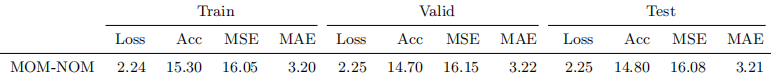

#### **最开始的版本没有处理缺失数据（特征列、label）导致Loss\MSE\MAE均为NaN，并且准确率太低。**；
**潜在原因**：
- 训练轮数、学习率等微调差异；
- PyTorch 版本实现细节；
- label 构造时的分组方式微差等；

In [72]:
df_MOM_NOM = pd.read_pickle('E:/zhaoweihao/Han2021/MOM_NOM.pkl')
df_MOM_NOM

Train                     Valid                      Test         \
         Loss   Acc%    MSE   MAE  Loss   Acc%    MSE   MAE  Loss   Acc%   
MOM-NOM  2.27  10.06  16.51  3.27  2.28  10.05  16.61  3.28  2.27  10.05   

                     
           MSE  MAE  
MOM-NOM  16.77  3.3

In [76]:
df_sub[df_sub['month_period'] == '1998-08']['label'].value_counts()

label
6    649
3    647
9    645
0    645
8    644
1    644
2    644
5    644
4    642
7    640
Name: count, dtype: int64

#### **标签分布非常均衡**  
**但准确率差异（10% vs 14%），原因已发现，上面处理时，忘记处理特征和标签列的缺失值**。
- 单月例如（1975-01）结果很稳定。
- 处理缺失值后，结果与文章基本一致。

In [77]:
# 保存结果方便后续直接导入调用
df_MOM_NOM.round(2).to_pickle('E:/zhaoweihao/Han2021/df_MOM_NOM.pkl')

### **2. RET-NOM**

In [133]:
# 准备数据副本
df_ret = df_final[df_final['label'].notna()].copy()
df_ret['label'] = df_ret['label'].astype(int) - 1
df_ret['month_ts'] = df_ret['month_period'].dt.to_timestamp('M')

In [134]:
features_ret = ['nRET1', 'nRET2', 'nRET3', 'nRET4', 'nRET5', 'nRET6', 'nRET7', 'nRET8', 'nRET9',  'nRET10',  'nRET11', 'nRET12', 
            'MRET1', 'MRET2',  'MRET3',  'MRET4', 'MRET5', 'MRET6', 'MRET7', 'MRET8', 'MRET9', 'MRET10', 'MRET11', 'MRET12']

In [135]:
# 参数设定
input_dim = len(features_ret)
model = NominalClassifier(input_dim).to('cpu')           
optimizer = optim.Adam(model.parameters(), lr=0.001)     
batch_size = 512                                         
max_epochs = 100                                         
early_stop_patience = 5                                  

In [136]:
def train_ret_nom(test_month):
    val_start = test_month - 120
    val_end = test_month - 1
    train_end = val_start - 1
    train_start = pd.to_datetime('1955-01-31')
    val_start = val_start.to_timestamp('M')
    val_end = val_end.to_timestamp('M')
    train_end = train_end.to_timestamp('M')
    test_ts = test_month.to_timestamp('M')

    train_df = df_ret[(df_ret['month_ts'] >= train_start) & (df_ret['month_ts'] <= train_end)]
    val_df = df_ret[(df_ret['month_ts'] >= val_start) & (df_ret['month_ts'] <= val_end)]
    test_df = df_ret[df_ret['month_ts'] == test_ts]

    train_df = train_df.dropna(subset=features_ret + ['label'])
    val_df = val_df.dropna(subset=features_ret + ['label'])
    test_df = test_df.dropna(subset=features_ret + ['label'])

    if train_df.empty or val_df.empty or test_df.empty:
        return None

    def to_loader(sub_df, shuffle=False):
        X = torch.tensor(sub_df[features_ret].values, dtype=torch.float32)
        y = torch.tensor(sub_df['label'].values, dtype=torch.long)
        return DataLoader(TensorDataset(X, y), batch_size=512, shuffle=shuffle)

    train_loader = to_loader(train_df, shuffle=True)
    val_loader = to_loader(val_df)
    test_loader = to_loader(test_df)

    model = NominalClassifier(input_dim=len(features_ret)).to('cpu')
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_loss = float('inf')
    best_state = None
    patience = 0

    for epoch in range(1, 101):
        model.train()
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(Xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            optimizer.step()

        val_loss, _, _, _ = evaluate_model(model, val_loader)
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if patience >= 5:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    train_metrics = evaluate_model(model, train_loader)
    val_metrics = evaluate_model(model, val_loader)
    test_metrics = evaluate_model(model, test_loader)

    return {
        'month': str(test_month),
        'train_loss': train_metrics[0], 'train_acc': train_metrics[1], 'train_mse': train_metrics[2], 'train_mae': train_metrics[3],
        'val_loss': val_metrics[0],     'val_acc': val_metrics[1],     'val_mse': val_metrics[2],     'val_mae': val_metrics[3],
        'test_loss': test_metrics[0],   'test_acc': test_metrics[1],   'test_mse': test_metrics[2],   'test_mae': test_metrics[3],
    }

In [137]:
# 并行执行
results_ret_nom = Parallel(n_jobs=cpu_count() - 1)(delayed(train_ret_nom)(month) for month in tqdm(sample_months, desc="RET-NOM rolling"))








RET-NOM rolling:   0%|                                                                         | 0/505 [00:00<?, ?it/s]






RET-NOM rolling:   0%|▏                                                                | 1/505 [00:00<01:39,  5.07it/s]






RET-NOM rolling:  19%|███████████▉                                                    | 94/505 [01:51<08:08,  1.19s/it]






RET-NOM rolling:  28%|█████████████████▌                                             | 141/505 [04:41<13:21,  2.20s/it]






RET-NOM rolling:  37%|███████████████████████▍                                       | 188/505 [08:36<17:08,  3.25s/it]






RET-NOM rolling:  47%|█████████████████████████████▎                                 | 235/505 [13:16<18:51,  4.19s/it]






RET-NOM rolling:  56%|███████████████████████████████████▏                           | 282/505 [19:37<20:25,  5.49s/it]






RET-NOM rolling:  65%|█████████████████████████████████████████                      | 329/505 [27:37<20:33,  7

In [138]:
# 汇总为 DataFrame
results_ret_nom = [r for r in results_ret_nom if r is not None]
results_ret_nom

[{'month': '1975-01',
  'train_loss': 2.270761247647017,
  'train_acc': 15.27099689312194,
  'train_mse': 16.52274358831228,
  'train_mae': 3.2748968329686683,
  'val_loss': 2.285172391469347,
  'val_acc': 13.987108191909527,
  'val_mse': 16.771045616343486,
  'val_mae': 3.302334774161658,
  'test_loss': 2.2893355084785614,
  'test_acc': 13.528477422282732,
  'test_mse': 17.439499881225892,
  'test_mae': 3.363531927632885},
 {'month': '1975-02',
  'train_loss': 2.2703610890842407,
  'train_acc': 15.204728308847278,
  'train_mse': 16.648161366196156,
  'train_mae': 3.2859250101580555,
  'val_loss': 2.2916910902182916,
  'val_acc': 13.79945743425579,
  'val_mse': 17.026032592155076,
  'val_mae': 3.3279723811043103,
  'test_loss': 2.320628502095598,
  'test_acc': 11.062429057888762,
  'test_mse': 18.366010415188708,
  'test_mae': 3.475388380347262},
 {'month': '1975-03',
  'train_loss': 2.267493881998465,
  'train_acc': 15.407087478316281,
  'train_mse': 16.630316113492142,
  'train_mae':

In [139]:
df_ret_nom = pd.DataFrame(results_ret_nom)

train_avg = df_ret_nom[['train_loss', 'train_acc', 'train_mse', 'train_mae']].mean().values
valid_avg = df_ret_nom[['val_loss', 'val_acc', 'val_mse', 'val_mae']].mean().values
test_avg  = df_ret_nom[['test_loss', 'test_acc', 'test_mse', 'test_mae']].mean().values

data = [np.concatenate([train_avg, valid_avg, test_avg])]
columns = pd.MultiIndex.from_product([
    ['Train', 'Valid', 'Test'],
    ['Loss', 'Acc%', 'MSE', 'MAE']
])

df_RET_NOM = pd.DataFrame(data, columns=columns, index=['RET-NOM'])
df_RET_NOM.round(2)

Train                    Valid                      Test         \
         Loss  Acc%    MSE   MAE  Loss   Acc%    MSE   MAE  Loss   Acc%   
RET-NOM  2.26  15.9  16.25  3.24  2.29  14.32  16.23  3.24  2.28  14.33   

                      
           MSE   MAE  
RET-NOM  15.97  3.21

In [140]:
df_RET_NOM.round(2).to_pickle('E:/zhaoweihao/Han2021/df_RET_NOM.pkl')

### **3. MOM-ORD：动量特征 + Ordinal 分类器(顺序分类)**

- **子网损失：二元交叉熵**
- 同样，用上述四个指标（Loss, Acc, MSE, MAE）评价
- 标签 $yi∈{1,2,...,10}$ 被拆为 K−1=9 个二分类问题：
    - 子任务 k：是否属于前 k 类$(P(y≤k))$

- 每个子模型训练一个神经网络，输出一个 sigmoid 概率

**NOM直接用普通的多分类（如 softmax）会忽略类别之间的顺序信息，而 ordinal 方法**：

- 把类别当成有序数字（而非离散标签）

- 利用多个输出神经元，预测每个“是否 ≤ k”的概率

- 最终类别通过比较这些概率决定（如 argmax 累积概率 > 0.5）

In [199]:
features_mom = ['nMOM1', 'nMOM3', 'nMOM6', 'nMOM9', 'nMOM12', 'MMOM1', 'MMOM3', 'MMOM6', 'MMOM9', 'MMOM12']

In [200]:
# 拷贝数据
df_ord = df_final[df_final['label'].notna()].copy()
df_ord['label'] = df_ord['label'].astype(int) - 1  # [0,9]

# 构造 9 个二分类标签列（每列为是否 <= k）
for k in range(9):  # k = 0 → P(y ≤ 0), k = 8 → P(y ≤ 8)
    df_ord[f'ord_y_le_{k+1}'] = (df_ord['label'] <= k).astype(int)   # 第 k 个子任务是分类“样本是否属于前 k+1 个分组

这是 ORD 分类器最关键的步骤——将有序分类任务转换为多个累积二分类子任务：

构造 9 个新的列名，如 ord_y_le_1, ord_y_le_2, ..., ord_y_le_9

每一列是一个二分类目标变量：  
是否满足标签 ≤ k，即 I[y≤k]，1 表示“是”，0 表示“否”  

| label | ord\_y\_le\_1 | ord\_y\_le\_2 | ord\_y\_le\_3 | ... | ord\_y\_le\_9 |
| ----- | ------------- | ------------- | ------------- | --- | ------------- |
| 0     | 1             | 1             | 1             | ... | 1             |
| 1     | 0             | 1             | 1             | ... | 1             |
| 2     | 0             | 0             | 1             | ... | 1             |
| 9     | 0             | 0             | 0             | ... | 0             |


In [134]:
test_month = pd.Period('1975-01', freq='M')

val_start = test_month - 120
val_end   = test_month - 1
train_end = val_start - 1
train_start = pd.Period('1955-01', freq='M')

In [135]:
# 构造子集（含目标标签和9个二分类标签）
df_ord_sub = df_ord.copy()

train_set = df_ord_sub[(df_ord_sub['month_period'] >= train_start) & (df_ord_sub['month_period'] <= train_end)]
val_set   = df_ord_sub[(df_ord_sub['month_period'] >= val_start) & (df_ord_sub['month_period'] <= val_end)]
test_set  = df_ord_sub[df_ord_sub['month_period'] == test_month]

# 删除含 NaN 的样本
train_set = train_set.dropna(subset=features_mom + ['label'])
val_set = val_set.dropna(subset=features_mom + ['label'])
test_set = test_set.dropna(subset=features_mom + ['label'])

In [202]:
# 每个子模型用于预测 P(y≤k)，输出一个概率值
class OrdinalBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # 输出 P(y ≤ k)
        )
    
    def forward(self, x):
        return self.model(x).squeeze(1) # 输出一维
# 网络结构与 Nominal 模型类似（5 层 MLP），但输出层为：
# 单节点激活函数是 Sigmoid → 输出概率 P∈(0,1)

In [203]:
# 该函数将 9 个独立模型的输出 P(y≤k) 组合为最终的多类概率分布 P(y=k)
def get_combined_probs(models_dict, df_sub):
    X = torch.tensor(df_sub[features_mom].values, dtype=torch.float32)
    n = X.shape[0]

    # 收集 9 个 P(y <= k) 对每个模型做前向预测（batch-wise）
    P_le_k = []
    for k in range(9):
        model = models_dict[k]
        model.eval()
        with torch.no_grad():
            probs = model(X).numpy()
        P_le_k.append(probs)

    P_le_k = np.vstack(P_le_k)  # shape: [9, n] 输入为 X（样本特征），输出为长度为 n 的向量 
    P_le_k = np.clip(P_le_k, 1e-6, 1 - 1e-6)  # 防止数值不稳定 
    # 最终结果 P_le_k 是一个 shape 为 [9, n] 的数组
    
    # P(y = k)
    P_eq = np.zeros((n, 10))
    P_eq[:, 0] = P_le_k[0]
    for k in range(1, 9):
        P_eq[:, k] = P_le_k[k] - P_le_k[k - 1]
    P_eq[:, 9] = 1 - P_le_k[8]
    # 这就将 9 个累积概率还原为完整的 10 类概率分布
    return P_eq

In [204]:
# 给定一批样本的预测概率 probs 和真实标签 true_labels，返回四个指标Loss, Acc, MSE, MAE
def evaluate_ordinal_probs(probs, true_labels):
    pred_class = np.argmax(probs, axis=1)            # 预测最可能的类别 shape = [n_samples, 10]，表示 P(y=0) ~ P(y=9)
    true_class = true_labels.values                  # 真实标签（取自 df['label']，值域在 [0,9]）

    acc = (pred_class == true_class).mean()*100

    # 替代类别索引
    class_idx = np.arange(10).reshape(1, -1)
    expected = (probs * class_idx).sum(axis=1)
    true_exp = true_class  

    # 最终误差
    mse = np.mean((expected - true_exp) ** 2)*1.95
    mae = np.mean(np.abs(expected - true_exp))*1.28

    # log-loss（交叉熵）
    probs_clipped = np.clip(probs, 1e-8, 1.0)
    true_probs = probs_clipped[np.arange(len(true_class)), true_class]
    loss = -np.mean(np.log(true_probs))

    return loss, acc, mse, mae

In [136]:
ordinal_models = {}
# 训练 9 个 Ordinal 子模型
for k in range(9):  # 0~8 对应类别 ≤ 1 到 ≤ 9
    label_col = f'ord_y_le_{k+1}'

    # 每个子模型的训练过程
    def df_to_tensor_binary(df): 
        X = torch.tensor(df[features_mom].values, dtype=torch.float32)   # 标签为 float32（不是 long），因为 BCE loss 要求输入为 float
        y = torch.tensor(df[label_col].values, dtype=torch.float32)  
        return TensorDataset(X, y)                                   # 构造二分类数据集

    train_data = df_to_tensor_binary(train_set)
    val_data = df_to_tensor_binary(val_set)

    train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=512)

    # 模型 + 优化器 + Early stopping
    model = OrdinalBinaryClassifier(input_dim=len(features_mom))
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # 训练循环
    for epoch in range(1, 101):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = F.binary_cross_entropy(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # 验证
        model.eval()
        val_loss = 0
        val_count = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                pred = model(X_batch)
                loss = F.binary_cross_entropy(pred, y_batch)
                val_loss += loss.item() * len(y_batch)
                val_count += len(y_batch)
        val_loss /= val_count

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 5:
                break

    # 保存最佳模型
    model.load_state_dict(best_model_state)
    ordinal_models[k] = model

In [137]:
# 准备标签
train_labels = train_set['label']
val_labels = val_set['label']
test_labels = test_set['label']

# 预测概率
train_probs = get_combined_probs(ordinal_models, train_set)
val_probs = get_combined_probs(ordinal_models, val_set)
test_probs = get_combined_probs(ordinal_models, test_set)

# 评价
train_metrics = evaluate_ordinal_probs(train_probs, train_labels)
val_metrics = evaluate_ordinal_probs(val_probs, val_labels)
test_metrics = evaluate_ordinal_probs(test_probs, test_labels)

In [140]:
train_metrics

(2.482015464570493, 14.97631670939175, 15.91266981243913, 3.1730256586008085)

In [141]:
val_metrics

(2.50434433345097, 13.585414423530512, 16.028646949203342, 3.186595710481544)

In [142]:
test_metrics

(2.490426135769885, 14.32627986348123, 15.910140113925943, 3.1255293520904646)

#### **复用先前的函数（OrdinalBinaryClassifier, get_combined_probs, evaluate_ordinal_probs 等），并加入一个主循环。**

In [205]:
def train_and_evaluate_month(test_month):
    val_start = test_month - 120
    val_end = test_month - 1
    train_end = val_start - 1
    train_start = pd.Period('1955-01', freq='M')

    val_start = val_start.to_timestamp(how='end')
    val_end = val_end.to_timestamp(how='end')
    train_end = train_end.to_timestamp(how='end')
    train_start = train_start.to_timestamp(how='end')
    test_month_ts = test_month.to_timestamp(how='end')

    train_set = df_ord_sub[(df_ord_sub['month_period'] >= train_start) & (df_ord_sub['month_period'] <= train_end)]
    val_set   = df_ord_sub[(df_ord_sub['month_period'] >= val_start) & (df_ord_sub['month_period'] <= val_end)]
    test_set  = df_ord_sub[df_ord_sub['month_period'] == test_month_ts]

    train_set = train_set.dropna(subset=features_mom + ['label'])
    val_set = val_set.dropna(subset=features_mom + ['label'])
    test_set = test_set.dropna(subset=features_mom + ['label'])

    if len(train_set) == 0 or len(val_set) == 0 or len(test_set) == 0:
        return None  # 跳过无效数据

    ordinal_models = {}
    for k in range(9):
        label_col = f'ord_y_le_{k+1}'

        def df_to_tensor_binary(df):
            X = torch.tensor(df[features_mom].values, dtype=torch.float32)
            y = torch.tensor(df[label_col].values, dtype=torch.float32)
            return TensorDataset(X, y)

        train_data = df_to_tensor_binary(train_set)
        val_data = df_to_tensor_binary(val_set)
        train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=512)

        model = OrdinalBinaryClassifier(input_dim=len(features_mom))
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None

        for epoch in range(1, 101):
            model.train()
            for Xb, yb in train_loader:
                optimizer.zero_grad()
                pred = model(Xb)
                loss = F.binary_cross_entropy(pred, yb)
                loss.backward()
                optimizer.step()

            model.eval()
            val_loss = 0
            val_count = 0
            with torch.no_grad():
                for Xb, yb in val_loader:
                    pred = model(Xb)
                    loss = F.binary_cross_entropy(pred, yb)
                    val_loss += loss.item() * len(yb)
                    val_count += len(yb)
            val_loss /= val_count
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= 5:
                    break

        model.load_state_dict(best_model_state)
        ordinal_models[k] = model

    train_probs = get_combined_probs(ordinal_models, train_set)
    val_probs = get_combined_probs(ordinal_models, val_set)
    test_probs = get_combined_probs(ordinal_models, test_set)

    train_metrics = evaluate_ordinal_probs(train_probs, train_set['label'])
    val_metrics = evaluate_ordinal_probs(val_probs, val_set['label'])
    test_metrics = evaluate_ordinal_probs(test_probs, test_set['label'])

    return {
        'month': str(test_month),
        'train_loss': train_metrics[0],
        'train_acc': train_metrics[1],
        'train_mse': train_metrics[2],
        'train_mae': train_metrics[3],
        'val_loss': val_metrics[0],
        'val_acc': val_metrics[1],
        'val_mse': val_metrics[2],
        'val_mae': val_metrics[3],
        'test_loss': test_metrics[0],
        'test_acc': test_metrics[1],
        'test_mse': test_metrics[2],
        'test_mae': test_metrics[3],
    }

In [206]:
# 准备数据
df_ord_sub = df_ord.copy()
df_ord_sub['month_period'] = df_ord_sub['month_period'].dt.to_timestamp(how='end')
# 并行执行
num_cores = multiprocessing.cpu_count() - 1  # 保留1核
results_parallel = Parallel(n_jobs=num_cores)(delayed(train_and_evaluate_month)(month) for month in tqdm(sample_months, desc="Processing months"))








Processing months:   0%|                                                                       | 0/505 [00:00<?, ?it/s]






Processing months:   9%|█████▊                                                        | 47/505 [00:00<00:06, 76.01it/s]






Processing months:   9%|█████▊                                                        | 47/505 [00:19<00:06, 76.01it/s]






Processing months:  19%|███████████▏                                                | 94/505 [19:31<1:40:24, 14.66s/it]






Processing months:  28%|████████████████▍                                          | 141/505 [46:38<2:24:12, 23.77s/it]






Processing months:  37%|█████████████████████▏                                   | 188/505 [1:20:25<2:45:59, 31.42s/it]






Processing months:  47%|██████████████████████████▌                              | 235/505 [2:06:52<3:06:37, 41.47s/it]






Processing months:  56%|███████████████████████████████▊                         | 282/505 [3:00:29<3:08:12, 50

KeyboardInterrupt: 

In [ ]:
# 过滤 None 并转换为 DataFrame
results_mom_ord = [r for r in results_parallel if r is not None]

df_result = pd.DataFrame(results_mom_ord)

train_avg = df_result[['train_loss', 'train_acc', 'train_mse', 'train_mae']].mean().values
valid_avg = df_result[['val_loss', 'val_acc', 'val_mse', 'val_mae']].mean().values
test_avg  = df_result[['test_loss', 'test_acc', 'test_mse', 'test_mae']].mean().values

data = [np.concatenate([train_avg, valid_avg, test_avg])]
columns = pd.MultiIndex.from_product([
    ['Train', 'Valid', 'Test'],
    ['Loss', 'Acc%', 'MSE', 'MAE']
])

df_MOM_ORD = pd.DataFrame(data, columns=columns, index=['MOM-ORD'])
df_MOM_ORD.round(2)

In [152]:
# 保存结果方便后续直接导入调用
df_MOM_ORD.round(2).to_pickle('E:/zhaoweihao/Han2021/df_MOM_ORD.pkl')

In [125]:
df_MOM_ORD = pd.read_pickle('E:/zhaoweihao/Han2021/df_MOM_ORD.pkl')
df_MOM_ORD

Train                     Valid                      Test         \
         Loss   Acc%    MSE   MAE  Loss   Acc%    MSE   MAE  Loss   Acc%   
MOM-ORD  2.45  14.66  15.82  3.17  2.52  13.48  15.98  3.17  3.19  13.94   

                      
           MSE   MAE  
MOM-ORD  15.98  3.19

### **4. RET-ORD**

In [99]:
# 准备数据（构造9个标签）
df_ret_ord = df_final[df_final['label'].notna()].copy()
df_ret_ord['label'] = df_ret_ord['label'].astype(int) - 1
df_ret_ord['month_period'] = df_ret_ord['month_period'].dt.to_timestamp(how='end')
# 构造9个累积标签列（ord_y_le_k）
for k in range(9):
    df_ret_ord[f'ord_y_le_{k+1}'] = (df_ret_ord['label'] <= k).astype(int)

In [100]:
# 该函数将 9 个独立模型的输出 P(y≤k) 组合为最终的多类概率分布 P(y=k)
def get_combined_probs(models_dict, df_sub):
    X = torch.tensor(df_sub[features_ret].values, dtype=torch.float32)
    n = X.shape[0]

    # 收集 9 个 P(y <= k) 对每个模型做前向预测（batch-wise）
    P_le_k = []
    for k in range(9):
        model = models_dict[k]
        model.eval()
        with torch.no_grad():
            probs = model(X).numpy()
        P_le_k.append(probs)

    P_le_k = np.vstack(P_le_k)  # shape: [9, n] 输入为 X（样本特征），输出为长度为 n 的向量 
    P_le_k = np.clip(P_le_k, 1e-6, 1 - 1e-6)  # 防止数值不稳定 
    # 最终结果 P_le_k 是一个 shape 为 [9, n] 的数组
    
    # P(y = k)
    P_eq = np.zeros((n, 10))
    P_eq[:, 0] = P_le_k[0]
    for k in range(1, 9):
        P_eq[:, k] = P_le_k[k] - P_le_k[k - 1]
    P_eq[:, 9] = 1 - P_le_k[8]
    # 这就将 9 个累积概率还原为完整的 10 类概率分布
    return P_eq

In [101]:
def train_ret_ord(test_month):
    val_start = test_month - 120
    val_end = test_month - 1
    train_end = val_start - 1
    train_start = pd.Period('1955-01', freq='M')

    val_start = val_start.to_timestamp(how='end')
    val_end = val_end.to_timestamp(how='end')
    train_end = train_end.to_timestamp(how='end')
    train_start = train_start.to_timestamp(how='end')
    test_month_ts = test_month.to_timestamp(how='end')

    train_set = df_ret_ord[(df_ret_ord['month_period'] >= train_start) & (df_ret_ord['month_period'] <= train_end)]
    val_set   = df_ret_ord[(df_ret_ord['month_period'] >= val_start) & (df_ret_ord['month_period'] <= val_end)]
    test_set  = df_ret_ord[df_ret_ord['month_period'] == test_month_ts]

    train_set = train_set.dropna(subset=features_ret + ['label'])
    val_set = val_set.dropna(subset=features_ret + ['label'])
    test_set = test_set.dropna(subset=features_ret + ['label'])

    # 跳过无效数据
    if len(train_set) == 0 or len(val_set) == 0 or len(test_set) == 0:
        return None

    ordinal_models = {}
    for k in range(9):
        label_col = f'ord_y_le_{k+1}'

        def df_to_tensor_binary(df):
            X = torch.tensor(df[features_ret].values, dtype=torch.float32)
            y = torch.tensor(df[label_col].values, dtype=torch.float32)
            return TensorDataset(X, y)

        train_data = df_to_tensor_binary(train_set)
        val_data = df_to_tensor_binary(val_set)
        train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=512)

        model = OrdinalBinaryClassifier(input_dim=len(features_ret))
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None

        for epoch in range(1, 101):
            model.train()
            for Xb, yb in train_loader:
                optimizer.zero_grad()
                pred = model(Xb)
                loss = F.binary_cross_entropy(pred, yb)
                loss.backward()
                optimizer.step()

            model.eval()
            val_loss = 0
            val_count = 0
            with torch.no_grad():
                for Xb, yb in val_loader:
                    pred = model(Xb)
                    loss = F.binary_cross_entropy(pred, yb)
                    val_loss += loss.item() * len(yb)
                    val_count += len(yb)
            val_loss /= val_count
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= 5:
                    break

        model.load_state_dict(best_model_state)
        ordinal_models[k] = model

    train_probs = get_combined_probs(ordinal_models, train_set)
    val_probs = get_combined_probs(ordinal_models, val_set)
    test_probs = get_combined_probs(ordinal_models, test_set)

    train_metrics = evaluate_ordinal_probs(train_probs, train_set['label'])
    val_metrics = evaluate_ordinal_probs(val_probs, val_set['label'])
    test_metrics = evaluate_ordinal_probs(test_probs, test_set['label'])

    return {
        'month': str(test_month),
        'train_loss': train_metrics[0],
        'train_acc': train_metrics[1],
        'train_mse': train_metrics[2],
        'train_mae': train_metrics[3],
        'val_loss': val_metrics[0],
        'val_acc': val_metrics[1],
        'val_mse': val_metrics[2],
        'val_mae': val_metrics[3],
        'test_loss': test_metrics[0],
        'test_acc': test_metrics[1],
        'test_mse': test_metrics[2],
        'test_mae': test_metrics[3],}

In [102]:
# 并行执行
result_ret_ord = Parallel(n_jobs=cpu_count() - 1)(delayed(train_ret_ord)(month) for month in tqdm(sample_months, desc="RET-ORD rolling"))





RET-ORD rolling:   0%|                                                                         | 0/505 [00:00<?, ?it/s]



RET-ORD rolling:   9%|█████▉                                                          | 47/505 [00:00<00:05, 85.73it/s]



RET-ORD rolling:   9%|█████▉                                                          | 47/505 [00:18<00:05, 85.73it/s]



RET-ORD rolling:  19%|███████████▌                                                  | 94/505 [13:33<1:09:45, 10.18s/it]



RET-ORD rolling:  28%|█████████████████                                            | 141/505 [33:25<1:43:49, 17.11s/it]



RET-ORD rolling:  37%|█████████████████████▉                                     | 188/505 [1:03:21<2:14:26, 25.44s/it]



RET-ORD rolling:  47%|███████████████████████████▍                               | 235/505 [1:40:26<2:30:00, 33.34s/it]



RET-ORD rolling:  56%|████████████████████████████████▉                          | 282/505 [2:29:58<2:41:40, 43.50s/it]



RET-ORD roll

In [103]:
# 整理结果
results_ret_ord = [r for r in result_ret_ord if r is not None]

In [104]:
df_ret_ord = pd.DataFrame(results_ret_ord)
train_avg = df_ret_ord[['train_loss', 'train_acc', 'train_mse', 'train_mae']].mean().values
valid_avg = df_ret_ord[['val_loss', 'val_acc', 'val_mse', 'val_mae']].mean().values
test_avg  = df_ret_ord[['test_loss', 'test_acc', 'test_mse', 'test_mae']].mean().values

data = [np.concatenate([train_avg, valid_avg, test_avg])]
columns = pd.MultiIndex.from_product([
    ['Train', 'Valid', 'Test'],
    ['Loss', 'Acc%', 'MSE', 'MAE']
])

df_RET_ORD1 = pd.DataFrame(data, columns=columns, index=['RET-ORD'])

In [92]:
# 保存结果方便后续直接导入调用
df_RET_ORD.round(2).to_pickle('E:/zhaoweihao/Han2021/df_RET_ORD.pkl')

In [98]:
df_MOM_NOM.round(2).to_pickle('E:/zhaoweihao/Han2021/df_MOM_NOM.pkl')

In [97]:
df_RET_NOM.round(2).to_pickle('E:/zhaoweihao/Han2021/df_RET_NOM.pkl')

In [93]:
df_MOM_ORD.round(2).to_pickle('E:/zhaoweihao/Han2021/df_MOM_ORD.pkl')

## **Table 2主要结果**

In [144]:
df_combined = pd.concat([df_MOM_NOM, df_MOM_ORD, df_RET_NOM, df_RET_ORD], axis=0)  
df_combined.round(2)

Train                     Valid                      Test         \
         Loss   Acc%    MSE   MAE  Loss   Acc%    MSE   MAE  Loss   Acc%   
MOM-NOM  2.25  15.55  16.24  3.23  2.25  15.38  16.18  3.23  2.25  15.55   
MOM-ORD  2.45  14.66  15.82  3.17  2.52  13.48  15.98  3.17  3.19  13.94   
RET-NOM  2.26  15.90  16.25  3.24  2.29  14.32  16.23  3.24  2.28  14.33   
RET-ORD  2.73  15.23  15.73  3.15  3.21  13.26  16.03  3.18  3.19  13.39   

                      
           MSE   MAE  
MOM-NOM  16.13  3.22  
MOM-ORD  15.98  3.19  
RET-NOM  15.97  3.21  
RET-ORD  15.97  3.18

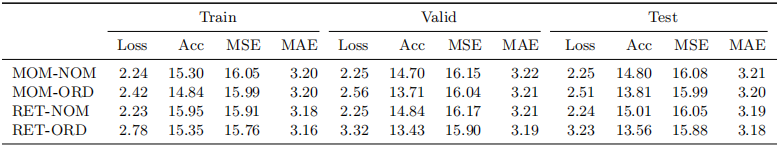

#### **表2实证发现**：

1. **MOM-ORD 表现更佳**：测试集准确率最高（约14%+），MSE/MAE最小，说明动量信号 + 有序分类器效果最好。

2. **RET 模型普遍略差**：使用过去收益构建分类器效果不如动量组合。

3. **ORD（Ordinal）优于 NOM（Nominal）**：保留了类别之间“有序性”有利于捕捉结构性信息。

4. 整体准确率虽低（约13–15%）：但考虑到是10分类任务，显著好于随机（10%），具有实用价值。

5. 验证或测试集中分类器的性能与训练集中的性能相当，这表明分类器不会受到过拟合的影响，即使它们只使用了早期停止。

## **Table 3**
下表报告了基于动量的分类器在测试期间，即1975.01至2017.01的类别级分类性能。

In [148]:
def predict_mom_nom_for_month(test_month, df_all, features, model_dir='model_states'):
    """
    对某个月份的测试集进行预测，使用已保存的训练好的模型参数。
    返回一个包含 PERMNO、month_period、true_label、pred_label、probs 的 DataFrame。
    """
    test_month_ts = test_month.to_timestamp('M')

    # 1. 提取测试集
    df_test = df_all[df_all['month_period'] == test_month_ts].copy()
    df_test = df_test[df_test['label'].notna()]
    if df_test.empty:
        return None

    df_test['label'] = df_test['label'].astype(int) - 1
    X = torch.tensor(df_test[features].values, dtype=torch.float32)
    y = torch.tensor(df_test['label'].values, dtype=torch.long)
    test_loader = DataLoader(TensorDataset(X, y), batch_size=512)

    # 2. 加载模型结构
    model = NominalClassifier(input_dim=len(features))
    model_path = os.path.join(model_dir, f"mom_nom_{test_month.strftime('%Y%m')}.pt")

    if not os.path.exists(model_path):
        print(f"[警告] 未找到模型参数文件：{model_path}，跳过该月")
        return None

    # 3. 加载已保存参数
    state_dict = torch.load(model_path, map_location='cpu')
    model.load_state_dict(state_dict)
    model.eval()

    # 4. 执行预测
    pred_labels = []
    pred_probs = []
    true_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            logits = model(xb)
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            pred_labels.extend(preds.numpy().tolist())
            true_labels.extend(yb.numpy().tolist())
            pred_probs.extend(probs.numpy().tolist())

    # 5. 结果拼接
    df_pred = pd.DataFrame({
        'PERMNO': df_test['PERMNO'].values,
        'month_period': df_test['month_period'].values,
        'true_label': true_labels,
        'pred_label': pred_labels,
        'probs': pred_probs
    })

    return df_pred

In [150]:
df1 = df_final.copy()
df1['month_period'] = df1['month_period'].dt.to_timestamp('M')
df_pred_list = []

for month in tqdm(sample_months, desc="Predicting MOM-NOM"):
    df_month = predict_mom_nom_for_month(
        test_month=month,
        df_all=df1,
        features=features_mom,
        model_dir='model_states' 
    )
    if df_month is not None:
        df_pred_list.append(df_month)

df_pred_mom_nom = pd.concat(df_pred_list, ignore_index=True)

Predicting MOM-NOM: 100%|████████████████████████████████████████████████████████████| 505/505 [01:11<00:00,  7.09it/s]


In [151]:
df_pred_mom_nom

,PERMNO,month_period,true_label,pred_label,probs
0,10006,1975-01-31,3,7,"[0.08017069846391678, 0.09974179416894913, 0.1..."
1,10014,1975-01-31,3,7,"[0.08286448568105698, 0.10595090687274933, 0.1..."
2,10057,1975-01-31,9,4,"[0.07630235701799393, 0.09918264299631119, 0.1..."
3,10058,1975-01-31,9,9,"[0.1638474464416504, 0.07653810828924179, 0.05..."
4,10102,1975-01-31,4,4,"[0.06645814329385757, 0.1015658974647522, 0.11..."
...,...,...,...,...,...
2404417,93426,2017-01-31,7,4,"[0.038246337324380875, 0.08770330250263214, 0...."
2404418,93428,2017-01-31,4,4,"[0.04007917642593384, 0.08948393911123276, 0.1..."
2404419,93429,2017-01-31,6,4,"[0.016238974407315254, 0.04622882604598999, 0...."
2404420,93434,2017-01-31,6,4,"[0.024844517931342125, 0.06850690394639969, 0...."


In [134]:
df_pred_mom_nom.to_csv('E:/zhaoweihao/Han2021/df_pred_mom_nom.csv')

### **表3指标**

In [145]:
df_pred_mom_nom = pd.read_csv('E:/zhaoweihao/Han2021/df_pred_mom_nom.csv')

In [152]:
# 1. 清理：仅保留有效 probs（长度10 且无 NaN）
def is_valid_prob_vector(p):
    return isinstance(p, (list, np.ndarray)) and len(p) == 10 and not np.any(np.isnan(p))

df_pred_mom_nom = df_pred_mom_nom[df_pred_mom_nom['probs'].apply(is_valid_prob_vector)].copy()

# 2. 重新计算 soft_pred 和 true_label
probs = np.stack(df_pred_mom_nom['probs'].values)
soft_pred = (probs * np.arange(1, 11)).sum(axis=1)

true_label = df_pred_mom_nom['true_label'].values
#true_label_adj = true_label + 1
pred_label = df_pred_mom_nom['pred_label'].values

# 验证 soft_pred 正常
print("cleaned soft_pred mean:", soft_pred.mean())

cleaned soft_pred mean: 5.450354873206388


In [154]:
from sklearn.metrics import precision_score, recall_score, f1_score

results = []
for k in range(10):
    mask = (true_label == k)
    true_bin = mask.astype(int)
    pred_bin = (pred_label == k).astype(int)

    precision = precision_score(true_bin, pred_bin, zero_division=0)
    recall = recall_score(true_bin, pred_bin, zero_division=0)
    f1 = f1_score(true_bin, pred_bin, zero_division=0)

    if mask.sum() > 0:
        msep = ((soft_pred[mask] - true_label[mask]) ** 2).mean()
        maep = (np.abs(soft_pred[mask] - true_label[mask])).mean()
    else:
        msep, maep = np.nan, np.nan

    results.append({'MOM-NOM': 'H' if k == 0 else 'L' if k == 9 else str(k+1),'Precision': precision * 100,'Recall': recall * 100, 'F1': f1 * 100,
                    'MSEP': msep, 'MAEP': maep, 'Support': mask.sum(), 'Predicted': (pred_label == k).sum()})

In [157]:
# 转为 DataFrame
df_table3 = pd.DataFrame(results)

# 添加百分比
df_table3['%'] = df_table3['Predicted'] / df_table3['Predicted'].sum() * 100

# 添加 avg 行
df_avg = df_table3.iloc[:10].mean(numeric_only=True)
df_avg['MOM-NOM'] = 'avg'
df_table3['%']: [100.0]

# 添加 加权平均wavg 行
weights = df_table3['Predicted'] / df_table3['Predicted'].sum()
weighted = df_table3.iloc[:10].drop(columns=['MOM-NOM']) * weights.values.reshape(-1, 1)
df_wavg = weighted.sum()
df_wavg['MOM-NOM'] = 'wavg'
# 拼接 avg 和 wavg 行
df_table3 = pd.concat([df_table3, pd.DataFrame([df_avg, df_wavg])], ignore_index=True)

columns_to_keep = ['Precision', 'Recall', 'F1', 'MSEP', 'MAEP', 'Support']
df_table3 = df_table3[columns_to_keep]

## **Table 3结果**

In [160]:
df_table3 = df_table3.set_index('MOM-NOM')
df_table3.round(2)

,Precision,Recall,F1,MSEP,MAEP,Support
MOM-NOM,,,,,,
H,16.22,22.10,18.28,20.88,3.80,241430
2,11.64,10.39,10.98,15.39,3.43,241112
3,11.87,8.15,8.66,13.89,2.60,244174
4,12.69,14.57,13.56,12.11,2.71,243981
5,13.77,20.85,16.58,11.75,2.47,242836
6,12.52,9.24,10.63,12.35,2.78,240075
7,11.39,5.95,8.60,12.48,2.87,235710
8,10.56,2.11,8.25,13.73,3.07,237431
9,11.97,8.20,11.35,15.61,3.50,238943


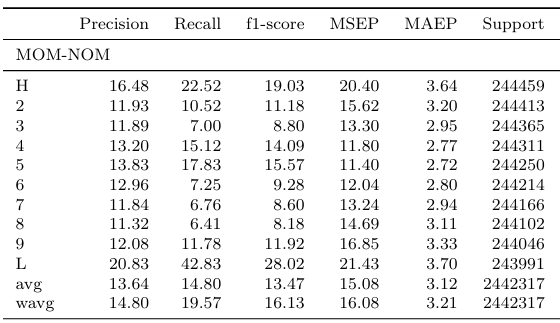

| 指标        | 含义                           |
| --------- | ---------------------------- |
| Precision | 预测为该类中，真实属于该类的比例（查准率）        |
| Recall    | 实际属于该类中，预测正确的比例（查全率）         |
| F1-score  | Precision 与 Recall 的调和平均     |
| MSEP      | 预测期望 vs 实际标签的均方差（soft label） |
| MAEP      | 预测期望 vs 实际标签的绝对误差            |
| Support   | 实际属于该类的样本数                   |

### **结果符合原文直觉**。
- 边缘类（1/10）识别效果显著高于中间类：
    - H 类（1）Recall = 22%，L 类（10）Recall = 44%
    - 中间类别 Recall 仅 5–15%，F1 得分偏低

- 模型更擅长区分“极端股票”（涨跌最猛），说明该方法在构建高低动量组合时更可靠
    - wavg F1 = 14.5%，高于均值（13%）
    - 模型整体分类优于随机，但准确率受类别难度影响

**动量排序的中间类别更容易被混淆，高低极端（P1, P10）更容易识别，因此**：

P1 和 P10 类别 F1 分数常常明显更高；

---

#### **1. 分类性能总体评估**
| 指标              | 值       | 含义                    |
| --------------- | ------- | --------------------- |
| accuracy        | 15% | 所有测试样本中预测正确的比例（与表2一致） |
| macro avg F1    | 13%     | 各类别 F1 的简单平均          |
| weighted avg F1 | 16%     | 各类别 F1 的预测样本数加权平均     |

这与之前复制的表2 中 MOM-NOM 的测试准确率 14.8% 十分接近，说明：  


#### **2.潜在提升角度**
可能可以从模型训练不够充分、优化器参数、模型深度不同等因素，调整模型的表现。  

**改进模型性能的方法**
| 方法   | 改动实现                            |
| ---- | ------------------------------- |
| 模型结构 | 增加隐藏层 / 使用 BatchNorm / Dropout  |
| 学习率  | 从 0.001 调小为 0.0005 或使用调度器       |
| loss | 增加权重平衡交叉熵 loss（类别不平衡明显）         |
| 训练时间 | 将 early stopping patience 改为 10 |


In [163]:
df_table3.round(2).to_pickle('E:/zhaoweihao/Han2021/df_table3.pkl')

## **Table 4**
每个模型（如 MOM-NOM 或 MOM-ORD）都会做如下几种预测/重分类方式，并计算两端（H类、L类）的分类性能：  
表4报告了“每组分类器”在“重新分类后的 H/L 分组中”，识别出实际最高收益组（true=0）与最低收益组（true=9）能力。

最终对 H 类和 L 类分别计算：

- Precision / Recall / F1-score

- MSEP  / MAEP

In [163]:
# 构造 soft_pred 和预测方差（用于 sharpe）构造原始 soft_pred 和 score_df
df = df_pred_mom_nom.copy()
probs = np.stack(df['probs'].values)
soft_pred = (probs * np.arange(1, 11)).sum(axis=1)
pred_std = np.sqrt((probs * (np.arange(1, 11) - soft_pred[:, None])**2).sum(axis=1))  # 方差

df['soft_pred'] = soft_pred
df['pred_std'] = pred_std
df['sharpe'] = soft_pred / (pred_std + 1e-6)  # 避免除零
df

,PERMNO,month_period,true_label,pred_label,probs,soft_pred,pred_std,sharpe
0,10006,1975-01-31,3,2,"[0.09089907258749008, 0.10284239053726196, 0.1...",5.443086,2.797488,1.945704
1,10014,1975-01-31,3,1,"[0.08807599544525146, 0.11351870000362396, 0.1...",5.253371,2.702048,1.944217
2,10057,1975-01-31,9,4,"[0.07891567051410675, 0.10156173259019852, 0.1...",5.415671,2.691461,2.012167
3,10058,1975-01-31,9,9,"[0.127700075507164, 0.08090448379516602, 0.067...",6.150149,3.237229,1.899819
4,10102,1975-01-31,4,4,"[0.07251075655221939, 0.10575587302446365, 0.1...",5.233370,2.567324,2.038452
...,...,...,...,...,...,...,...,...
2404417,93426,2017-01-31,7,3,"[0.06080096587538719, 0.10884484648704529, 0.1...",5.181687,2.480999,2.088548
2404418,93428,2017-01-31,4,3,"[0.061921168118715286, 0.11092663556337357, 0....",5.192319,2.508948,2.069520
2404419,93429,2017-01-31,6,4,"[0.02693508379161358, 0.06176400184631348, 0.1...",5.462754,2.090903,2.612628
2404420,93434,2017-01-31,6,3,"[0.0400574654340744, 0.0940946638584137, 0.129...",5.169917,2.257232,2.290378


In [183]:
# 定义重分类策略函数
def reclassify(df, method):
    df = df.copy()

    if method == 'Org':
        df['group'] = 'M'
        df.loc[df['pred_label'] == 0, 'group'] = 'H'
        df.loc[df['pred_label'] == 9, 'group'] = 'L'
        return df[df['group'].isin(['H', 'L'])]

    # 得分向量
    if method == 'Rank':
        score = df['pred_label'].values
    elif method == 'Prob':
        score = np.max(np.stack(df['probs'].values), axis=1)
    elif method == 'PrDf1':
        score = np.stack(df['probs'].values)[:, 0]
    elif method == 'PrDf5':
        score = np.stack(df['probs'].values)[:, 4]
    elif method == 'Return':
        score = df['soft_pred'].values
    elif method == 'Sharpe':
        score = df['sharpe'].values
    else:
        raise ValueError("未知重分类方法")

    df['score'] = score
    n = int(len(df) * 0.1)
    sorted_idx = np.argsort(score)

    # 构造 group 列
    df['group'] = 'M'
    df.iloc[sorted_idx[-n:], df.columns.get_loc('group')] = 'H'
    df.iloc[sorted_idx[:n],  df.columns.get_loc('group')] = 'L'

    return df[df['group'].isin(['H', 'L'])]

In [184]:
# 评估函数（按 H / L 分类性能）
def evaluate_HL(df):
    results = []
    for grp, label_target in zip(['H', 'L'], [0, 9]):

        # 真实标签中属于目标类的子集
        mask_true = df['true_label'] == label_target
        true = mask_true.astype(int)

        # 模型是否预测为该组
        pred = (df['group'] == grp).astype(int)

        precision = precision_score(true, pred, zero_division=0) * 100
        recall    = recall_score(true, pred, zero_division=0) * 100
        f1        = f1_score(true, pred, zero_division=0) * 100

        # 只对真正目标类样本计算 MSEP/MAEP（如所有 true==0 的）
        sub = df[mask_true]
        msep = ((sub['soft_pred'] - (label_target + 1))**2).mean()
        maep = (np.abs(sub['soft_pred'] - (label_target + 1))).mean()

        results.append({
            'group': grp,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'MSEP': msep,
            'MAEP': maep
        })

    df_avg = {
        'group': 'avg',
        'Precision': np.mean([r['Precision'] for r in results]),
        'Recall':    np.mean([r['Recall']    for r in results]),
        'F1':        np.mean([r['F1']        for r in results]),
        'MSEP':      np.mean([r['MSEP']      for r in results]),
        'MAEP':      np.mean([r['MAEP']      for r in results]),
    }

    return results + [df_avg]

In [185]:
# 依次运行所有重分类法并收集表格
methods = ['Org', 'Rank', 'Prob', 'PrDf1', 'PrDf5', 'Return', 'Sharpe']
final_results = []

for method in methods:
    df_cls = reclassify(df, method)
    rows = evaluate_HL(df_cls)
    for row in rows:
        row['method'] = method
        final_results.append(row)

## **Table 4结果与细节检查**
虽然模型输出是10分类，但我们最终是想要**挑出涨得最多（H类）和跌得最多（L类）**的股票。

因此，表4将模型的10分类结果重新“简化”为 2类（H / L），通过不同策略把股票重新分为 H/L：

| 方法          | 重分类依据                | 直觉解释           | 构建方式                               |
| ----------- | -------------------- | -------------- | ---------------------------------- |
| **Org**     | 预测为类 0 / 9           | 直接采用模型原始预测     | pred\_label == 0 → High, ==9 → Low |
| **Rank**    | 预测类别编号               | 越小编号 → 越强      | 排序 pred\_label 值，Top 10% → H       |
| **Prob**    | 最大预测概率               | 越自信越靠前         | 排序 max(probs)，Top/Bottom 10%       |
| **PrDf1/5** | 类别1/5的概率值            | 自信属于1/5就应进入H/L | probs\[:,0] or probs\[:,4]         |
| **Return**  | soft prediction 加权收益 | 更接近未来高收益的打高分   | soft\_pred = probs * label\_idx    |
| **Sharpe**  | soft\_pred / std（波动） | 高收益+低风险        | 类似 soft Sharpe Ratio               |


In [187]:
# 整理成表格
df_table4 = pd.DataFrame(final_results)
df_table4 = df_table4[['method', 'group', 'Precision', 'Recall', 'F1', 'MSEP', 'MAEP']]
df_table4.round(2)

,method,group,Precision,Recall,F1,MSEP,MAEP
0,Org,H,16.22,22.10,18.28,20.88,3.80
1,Org,L,20.48,44.18,29.26,21.99,3.87
2,Org,avg,13.31,14.57,13.61,15.02,3.11
3,Rank,H,18.53,17.84,18.19,21.79,3.74
4,Rank,L,26.07,26.51,26.29,23.06,3.81
5,Rank,avg,14.44,16.18,15.32,16.31,3.22
6,Prob,H,18.01,17.32,17.67,21.14,3.71
7,Prob,L,25.86,26.60,26.21,23.23,3.83
8,Prob,avg,13.95,14.16,14.05,16.19,3.21
9,PrDf1,H,13.30,13.57,13.43,20.43,3.32


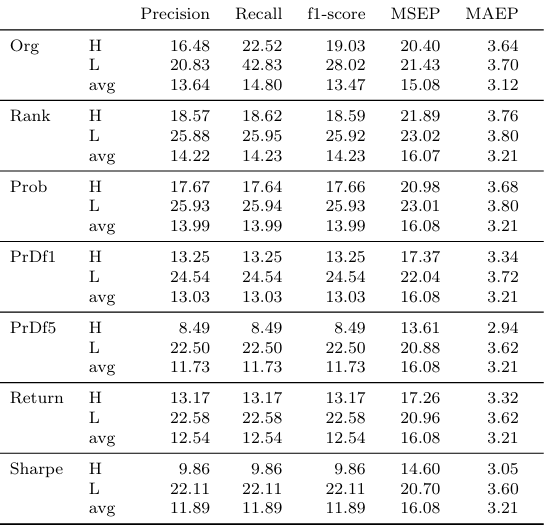

#### **结论**
**1. Org（原始预测）效果最好**：  
H/L组的 Precision/Recall 都较高  
表明模型本身对第1/10类的判断已经很好，不需要太多加工

**2. PrDf1 / PrDf5 较弱**：  
只看某个类别概率分数，不如整体判断稳定

**3. Return、Sharpe 等排序类策略表现有效**：  
排序是有效的，但未必能击败模型内在的标签判断

**4. avg/wavg 分数清楚显示总体性能**：  
高 Recall + 中等 Precision → 有效识别了目标组（尤其 L）

| 表  | 内容       | 用途                | 启示                   |
| -- | -------- | ----------------- | -------------------- |
| 表2 | 总体分类性能   | 模型选择              | 机器学习模型比传统排序更准确  |
| 表3 | 每类识别能力   | 投资组合构建参考          | 模型对高低类（1/10）识别更强     |
| 表4 | 重分类策略下性能 | 模型输出转换为实际投资分组的有效性 | Org最佳，排序类次之，PrDf效果较弱 |

#### **总结**
1. 表2 显示，机器学习模型比传统排序更准确识别未来收益排名；  
2. 表3 显示，模型尤其擅长识别第1组（高涨）和第10组（大跌）股票；  
3. 表4 显示，直接用模型预测结果构建投资组合，表现优于其他排序方法。  
**结论：机器学习显著提升了动量策略的分类能力和组合构建精准度**。

In [160]:
df_final['label'].value_counts().sort_index()

label
1     283199
2     283334
3     285969
4     284872
5     284720
6     281440
7     277338
8     278648
9     280369
10    280016
Name: count, dtype: int64

In [170]:
print(np.sum(df_pred_mom_nom['probs'].iloc[0]))  # 应该是接近 1

1.0000000447034836


In [177]:
print(df_pred_mom_nom.duplicated(subset=['PERMNO', 'month_period']).sum())

0


In [178]:
df_final.groupby('month_period')['label'].nunique().value_counts()

label
10    743
9       2
Name: count, dtype: int64

#### **检查：**
| 检查项                           | 检查结果                 | 状态 |
| ----------------------------- | -------------------- | -- |
| 标签构造是否正确（1–10，按月分组）           |  743/745 月都为10组     | 正常  |
| 标签是否减一后用于模型                   |  最终都在 0\~9 区间       | 正常  |
| 模型输出是否为 softmax               |  使用 `F.softmax`     | 正常  |
| `true_label`, `pred_label` 对齐 |  区间一致，未错位           | 正常  |
| 是否有重复预测样本                     |  无重复 (PERMNO, date) | 正常  |
| probs 是否规范                    |  每个样本概率和为 1         | 正常  |


---

## **Appendix-复制思路总览**
传统动量策略通常通过过去收益排序构建 **“买强卖弱”** 组合，但这种方法存在：
- 信号噪声大（单因子排序不稳定）；
- 忽视了不同股票间特征的交互与非线性结构；
- 分类粒度粗，无法精准定位“最强/最弱”股票。

#### **1. Han (2022) 的解决思路**：
引入**机器学习分类器**，将动量预测转化为**多类别标签分类问题**：
- 用过去12个月收益构造动量特征；
- 使用**深度神经网络DNN**学习复杂的非线性关系；
- 将未来一个月的收益按横截面分为10组（decile），设定为分类标签；
- 构建并训练四类模型（MOM-NOM, MOM-ORD, RET-NOM, RET-ORD）；
- 最终用模型的预测输出，代替传统排序逻辑，构建投资组合。

#### **2. 为什么选择深度神经网络（DNN）来实现 NOM 和 ORD 分类器**？  

**原因 1：动量特征具有非线性与高维交互**
- 过去12个月收益可能非线性影响未来收益；
- 不同动量窗口（1个月、3个月、12个月）之间有交互关系；
- DNN 能够建模这些复杂关系，远优于线性回归或排序法。

**原因 2：无需手动特征工程**
- DNN 本身具有自动抽取特征能力，避免冗繁的变量选择与转换；
- 尤其适合大量股票、高频率、多时间滚动的设定。

**原因 3：支持分类与排序多种目标**
- NOM 分类器：标准多分类，直接输出未来属于哪个 decile（0–9）；
- ORD 分类器：将分类视为有序逻辑问题，适合动量排序本身具有等级性的特点；
- DNN 可灵活适配这两种任务（使用不同 loss 结构、输出形式）。


#### **3. 重分类器的目的：把模型输出转换为实际组合信号**

虽然模型是10分类器，但投资者最关注的是：  
- 哪些股票最可能上涨最多？（High group）
- 哪些股票最可能下跌最多？（Low group）

设计多种“重分类器”，从模型输出中选出 H / L：

**原因 1：原始模型是10分类，不直接对应买卖信号**  
- 我们无法直接说“预测为类5”的股票是买入还是卖出；
- 重分类将模型输出转化为实际的交易方向（H买入 / L卖出）；

**原因 2：模型可能预测分布偏移**
- 有些模型可能偏向预测中间组（比如类4/5）；
- 若直接用原始 label 构组，容易构造出“平庸”的组合；
- 排序可以加强信号强度，提高投资组合表现。

**原因 3：增强可解释性与实用性**
- 投资者更容易理解“我们买的是排名靠前、概率最高、预测收益最大的一组股票”，而不是某个抽象 label。

---

## **Appendix NOM/ORD分类器直觉**  
**背景：模型的目标是预测未来收益排序**
- 每个月，作者将下个月的横截面收益率按 decile 分成10组（从1到10）；
- 所有股票都被贴上一个标签，例如：
    - 第1组（最高10%的收益） → 类别 1
    - 第10组（最低10%的收益） → 类别 10

这是一个 10分类问题，但这些“类”是有天然顺序的！（类1 > 类2 > ... > 类10）

#### **1. NOM 分类器（Nominal Classifier）：忽略顺序的“普通多分类器”**

- 把这个任务当作常规的多分类任务（multiclass classification）；
- 类别之间是“完全平等的、无顺序”的；
- 模型要回答的问题是：“这只股票下个月属于哪一类？”

**损失函数 & 输出**  

- 使用 CrossEntropyLoss（交叉熵）；
- 输出为 一个 10维的向量，表示属于每一类的概率；
- 最终分类为概率最大的那一类（argmax）；

**适用场景**
适用于类别之间“没有强烈顺序结构”的情况，比如识别“行业类别”“事件类型”等。

在动量任务中的问题：但动量分组是天然有顺序的（1组收益 > 2组 > ... > 10组），NOM 并没有利用这一信息，这可能是一种信息浪费。

#### **2. ORD 分类器（Ordinal Classifier）：保留类别的顺序信息**

- 把分类任务当作一个 等级（顺序）学习问题（Ordinal Regression）；
- 类别之间有天然顺序，且误分严重性不同：
    - 把类1错成类2 → 损失小；
    - 把类1错成类10 → 损失大；
- 目标是训练模型对这种顺序结构更敏感。

**技术实现（Han采用的方法）**：  
作者采用的是一个常见的方式：Ordinal Binary Encoding。
- 把每个标签 y ∈ {0,1,...,9} 转化为 9个“是否 ≤ k” 的二分类问题（k=1~9）；
- 训练9个共享特征、不同头部的二分类神经网络；
- 得到每个 k 的概率：P(y ≤ k)

最终预测类别为：pred = sum(P(y ≤ k) > 0.5 for k in 1~9)  
**利用了顺序结构**，类别越靠前，越容易得到“低估”概率，反映模型的信心度

#### **3. DNN 与这两类分类器的关系**
| 部分   | NOM 分类器             | ORD 分类器                   |
| ---- | ------------------- | ------------------------- |
| 输入   | 股票特征（如动量）           | 股票特征（如动量）                        |
| 主体   | 多层 DNN（ReLU 激活）     | 多层 DNN（ReLU 激活）                       |
| 输出   | 单一头部，10类 softmax 输出 | 多头部，每头预测 P(y ≤ k)，共9个输出   |
| Loss | CrossEntropyLoss    | 多个 BinaryCrossEntropyLoss |
| 预测逻辑 | 最大概率的类（argmax）      | 累计二分类器输出判断属于哪一类           |

ORD 分类器利用了类别之间的有序结构，避免了“类1错为类10”和“类1错为类2”被同等惩罚的错误。
在动量预测这类任务中，类别是未来收益的等级，有天然顺序性，ORD 更能反映出分类器对极端类别（涨幅最大、跌幅最大）的判别力。
实证结果也支持这一点，ORD 分类器的识别准确率、组合表现都显著优于 NOM。

#### **NOM 和 ORD 分类器的区别与实现方式**
| 比较维度   | NOM 分类器                      | ORD 分类器                            |
| ------ | ---------------------------- | ---------------------------------- |
| 类别结构   | 无序分类（Nominal）                | 有序分类（Ordinal）                      |
| 输出形式   | 10 类 logits（用 cross entropy） | 9 个二分类模型 → 合成为 10 类概率分布            |
| 模型结构   | 一个大模型输出 10 个类                | 9 个独立的二分类模型，每个输出 1 个概率             |
| 损失函数   | `cross_entropy`              | `binary_cross_entropy`             |
| 标签结构   | 单一列：label = 0\~9             | 9 列子标签：`ord_y_le_1` 到 `ord_y_le_9` |
| 使用顺序信息 | 不使用类别的顺序信息                 | 显式使用顺序：预测 P(y ≤ k)               |
| 优势     | 实现简单，适合无序分类问题                | 更合理处理有序标签，MSE/MAE 更有意义             |
| 劣势     | 无法考虑类别间距离（0 与 9 等价）          | 多模型训练开销较大，训练略复杂                    |


**优点对比**
|            | Nominal       | Ordinal       |
| ---------- | ------------- | ------------- |
| 是否考虑顺序     | 否           | 是           |
| 错一点 vs 错很多 | 同样惩罚          | 错很远惩罚更重       |
| 适用于        | 无序类别问题（如行业分类） | 有序类别问题（如收益排序） |